In [1]:
import os
import warnings

# Data Manipulation & Math
import numpy as np
import pandas as pd
import scipy
from scipy.stats import uniform, randint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (Scikit-Learn)
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Boosting (XGBoost)
import xgboost as xgb
from xgboost import XGBClassifier

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [3]:
base_dir = '/content/drive/MyDrive/btc-ml'

def load_csvs_from_folder(folder_path):

    csv_files = [f for f in os.listdir(folder_path)]
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in csv_files]
    return pd.concat(dfs, ignore_index=True)


train = load_csvs_from_folder(os.path.join(base_dir, 'training'))
val = load_csvs_from_folder(os.path.join(base_dir, 'validation'))
test = load_csvs_from_folder(os.path.join(base_dir, 'test'))


df = pd.concat([train, val, test], ignore_index=True)


Display dataset information (dtypes, non-null counts), show statistical summary,
check for missing values

In [4]:
print(df.describe())

          open_time           open           high            low  \
count  6.998400e+05  699840.000000  699840.000000  699840.000000   
mean   1.725062e+12   72252.322803   72282.840946   72221.679294   
std    1.212159e+10   17323.361323   17330.704011   17316.093355   
min    1.704067e+12   38560.600000   38580.100000   38545.000000   
25%    1.714565e+12   61021.975000   61045.000000   61000.200000   
50%    1.725062e+12   67468.100000   67497.400000   67439.200000   
75%    1.735560e+12   87282.325000   87320.025000   87245.200000   
max    1.746058e+12  109529.200000  110000.000000  109017.700000   

               close         volume    close_time  
count  699840.000000  699840.000000  6.998400e+05  
mean    72252.397224     180.223656  1.725062e+12  
std     17323.344869     331.547240  1.212159e+10  
min     38560.600000       0.000000  1.704067e+12  
25%     61022.000000      44.972000  1.714565e+12  
50%     67468.100000      88.703500  1.725062e+12  
75%     87282.425000   

In [5]:
print()
print('----Null values :')
print(df.isnull().sum())

print()
print("----Missing values :")
(df.isna().sum())


----Null values :
open_time     0
open          0
high          0
low           0
close         0
volume        0
close_time    0
dtype: int64

----Missing values :


,0
open_time,0
open,0
high,0
low,0
close,0
volume,0
close_time,0


Convert timestamp columns from milliseconds to datetime objects :

In [6]:
train['open_time'] = pd.to_datetime(train['open_time'], unit='ms')
train['close_time'] = pd.to_datetime(train['close_time'], unit='ms')

val['open_time'] = pd.to_datetime(val['open_time'], unit='ms')
val['close_time'] = pd.to_datetime(val['close_time'], unit='ms')

test['open_time'] = pd.to_datetime(test['open_time'], unit='ms')
test['close_time'] = pd.to_datetime(test['close_time'], unit='ms')

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

 Visualise Price Trends: Plot BTC closing price over
time (sample hourly). Calculate price statistics (min, max, mean, std).

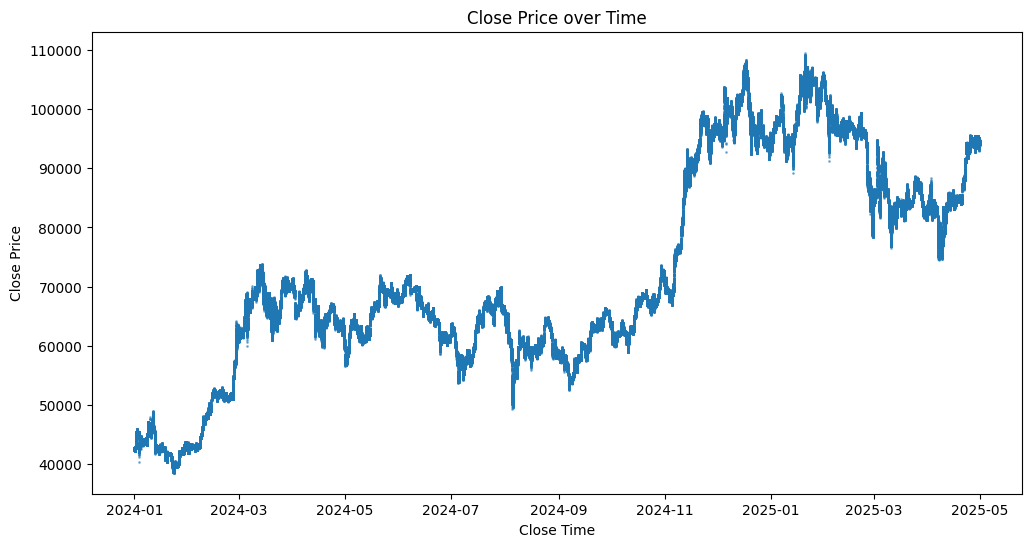

In [7]:
plt.figure(figsize=(12,6))
plt.xlabel('Close Time')
plt.ylabel('Close Price')
plt.title('Close Price over Time')
plt.scatter(df.close_time, df.close,s=1, alpha=0.5)

In [8]:
print('Statistics :')
print()
print('mean =',df.close.mean())
print('max =',df.close.max())
print('min =',df.close.min())
print('std =',df.close.std())


Statistics :

mean = 72252.39722443701
max = 109532.6
min = 38560.6
std = 17323.344868819826


# Feature Engineering

The following engineered features are added to enhance BTC price prediction:

1. Price-based Features

price_range — Difference between high and low price.

price_change — Difference between close and open price.

price_change_pct — Percentage price change from open to close.

2. Moving Averages (MA)

ma_5, ma_10, ma_20, ma_50 — Simple moving averages over different windows.

ma_diff_5_10, ma_diff_10_20 — Differences between moving averages to capture short/long trend shifts.

3. RSI (Relative Strength Index)

rsi — Momentum oscillator indicating overbought/oversold conditions.

4. MACD Indicators

macd — Difference between 12-EMA and 26-EMA.

macd_signal — 9-EMA of the MACD.

macd_diff — MACD histogram value (trend strength indicator).

5. Volatility Metrics

volatility_10, volatility_20 — Rolling standard deviation of the closing price.

6. Volume-based Features

volume_ma_5, volume_ma_10 — Moving averages of trading volume.

volume_ratio — Current volume relative to its 10-period average.

7. Momentum Indicators

momentum_5, momentum_10 — Price change over 5 or 10 periods.

In [9]:
def create_features(df):
    """Create technical indicators and features for BTC price prediction"""
    df = df.copy()
    # Price-based features
    df['price_range'] = df['high'] - df['low']
    df['price_change'] = df['close'] - df['open']
    df['price_change_pct'] = (df['close'] - df['open']) / df['open'] * 100
    # Moving Averages
    df['ma_5'] = df['close'].rolling(window=5).mean()
    df['ma_10'] = df['close'].rolling(window=10).mean()
    df['ma_20'] = df['close'].rolling(window=20).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()
    # Moving Average Differences
    df['ma_diff_5_10'] = df['ma_5'] - df['ma_10']
    df['ma_diff_10_20'] = df['ma_10'] - df['ma_20']
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    # MACD
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    # Volatility
    df['volatility_10'] = df['close'].rolling(window=10).std()
    df['volatility_20'] = df['close'].rolling(window=20).std()
    # Volume features
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_10']
    # Momentum
    df['momentum_5'] = df['close'] - df['close'].shift(5)
    df['momentum_10'] = df['close'] - df['close'].shift(10)
    return df

# Apply feature engineering
print("Creating features for training data...")
df_train = create_features(train)
print("Creating features for validation data...")
df_val = create_features(val)
print("Creating features for test data...")
df_test = create_features(test)
print("\nFeatures created successfully!")
print(f"Total number of features: {df_train.shape[1]}")
print("\nNew features:")
print(df_train.columns.tolist())

Creating features for training data...
Creating features for validation data...
Creating features for test data...

Features created successfully!
Total number of features: 27

New features:
['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'price_range', 'price_change', 'price_change_pct', 'ma_5', 'ma_10', 'ma_20', 'ma_50', 'ma_diff_5_10', 'ma_diff_10_20', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'volatility_10', 'volatility_20', 'volume_ma_5', 'volume_ma_10', 'volume_ratio', 'momentum_5', 'momentum_10']


2. Create binary classification target:
- 1 (UP): Future price (30 min ahead) > current price
- 0 (DOWN): Future price (30 min ahead) ≤ current price

In [10]:
df_train['future_close'] = df_train['close'].shift(-30)
df_train['target'] = (df_train['future_close'] > df_train['close'])
df_train.loc[df_train['future_close'].isna(), 'target'] = pd.NA

df_test['future_close'] = df_test['close'].shift(-30)
df_test['target'] = (df_test['future_close'] > df_test['close'])
df_test.loc[df_test['future_close'].isna(), 'target'] = pd.NA

df_val['future_close'] = df_val['close'].shift(-30)
df_val['target'] = (df_val['future_close'] > df_val['close'])
df_val.loc[df_val['future_close'].isna(), 'target'] = pd.NA


We drop the future_close column because it is only an intermediate column used to compute the target.
Once the target is created, future_close is no longer needed for training or inference. Keeping it would leak future information into the model, which would cause data leakage and unrealistically high performance.

In [11]:
df_train.drop(columns=['future_close'], inplace=True)
df_val.drop(columns=['future_close'], inplace=True)
df_test.drop(columns=['future_close'], inplace=True)

In [12]:
df_train['target'].isna().sum()
df_val['target'].isna().sum()
df_test['target'].isna().sum()

np.int64(30)

These checks count the number of missing values in the target column for the training, validation, and test sets.
The presence of NaN values is expected, because when we concatenated or aligned the datasets earlier, some rows no longer had a corresponding future value to compute the target.

In [13]:
print(df_train.target.isna().sum())

print(df_train.shape)
df_train.dropna(subset=['target'], inplace=True)
print(df_train.shape)

df_test.dropna(subset=['target'], inplace=True)
df_val.dropna(subset=['target'], inplace=True)

30
(527040, 28)
(527010, 28)


3. Visualise target distribution : The distribution between up and down cases is almost perfectly balanced, close to a 50/50 split. This means the task is quite challenging, similar to predicting the outcome of a coin toss.
However, the good news is that the dataset is well-balanced, so the model won’t suffer from class imbalance issues.

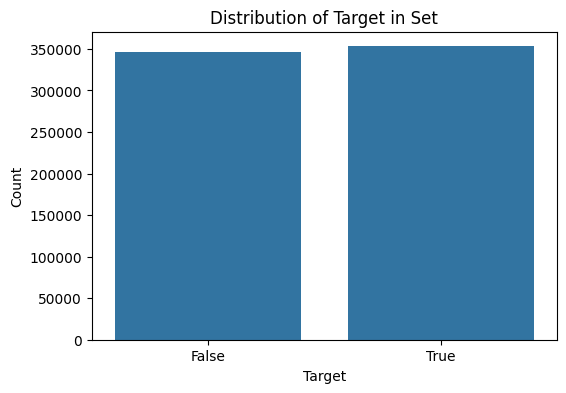

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=pd.concat([df_train,df_val,df_test]))
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target in Set')
plt.show()

4. Prepare Final Dataset. Remove rows with NaN values. Define feature columns
(exclude time, OHLCV, target). Create X and y splits for all datasets (e.g.,
X_train, X_val, X_test).

In [15]:
df_train.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'price_range', 'price_change', 'price_change_pct', 'ma_5', 'ma_10',
       'ma_20', 'ma_50', 'ma_diff_5_10', 'ma_diff_10_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'volatility_10', 'volatility_20',
       'volume_ma_5', 'volume_ma_10', 'volume_ratio', 'momentum_5',
       'momentum_10', 'target'],
      dtype='object')

In [16]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train['target'].astype(int)
df_plot = df_train.copy()
df_train.drop(['close_time','open_time', 'open','high','close','low','volume', 'target'],axis = 1,inplace=True)

y_test = df_test['target'].astype(int)
df_test.drop(['close_time','open_time', 'open','high','close','low','volume', 'target'],axis = 1,inplace=True)

y_val = df_val['target'].astype(int)
df_val.drop(['close_time','open_time', 'open','high','close','low','volume', 'target'],axis = 1,inplace=True)

These columns are dropped because the model uses derived features instead of raw price/volume data, and keeping them could cause data leakage or unnecessary redundancy.

In [17]:

X_val = df_val
X_train = df_train
X_test = df_test

# Data Exploration

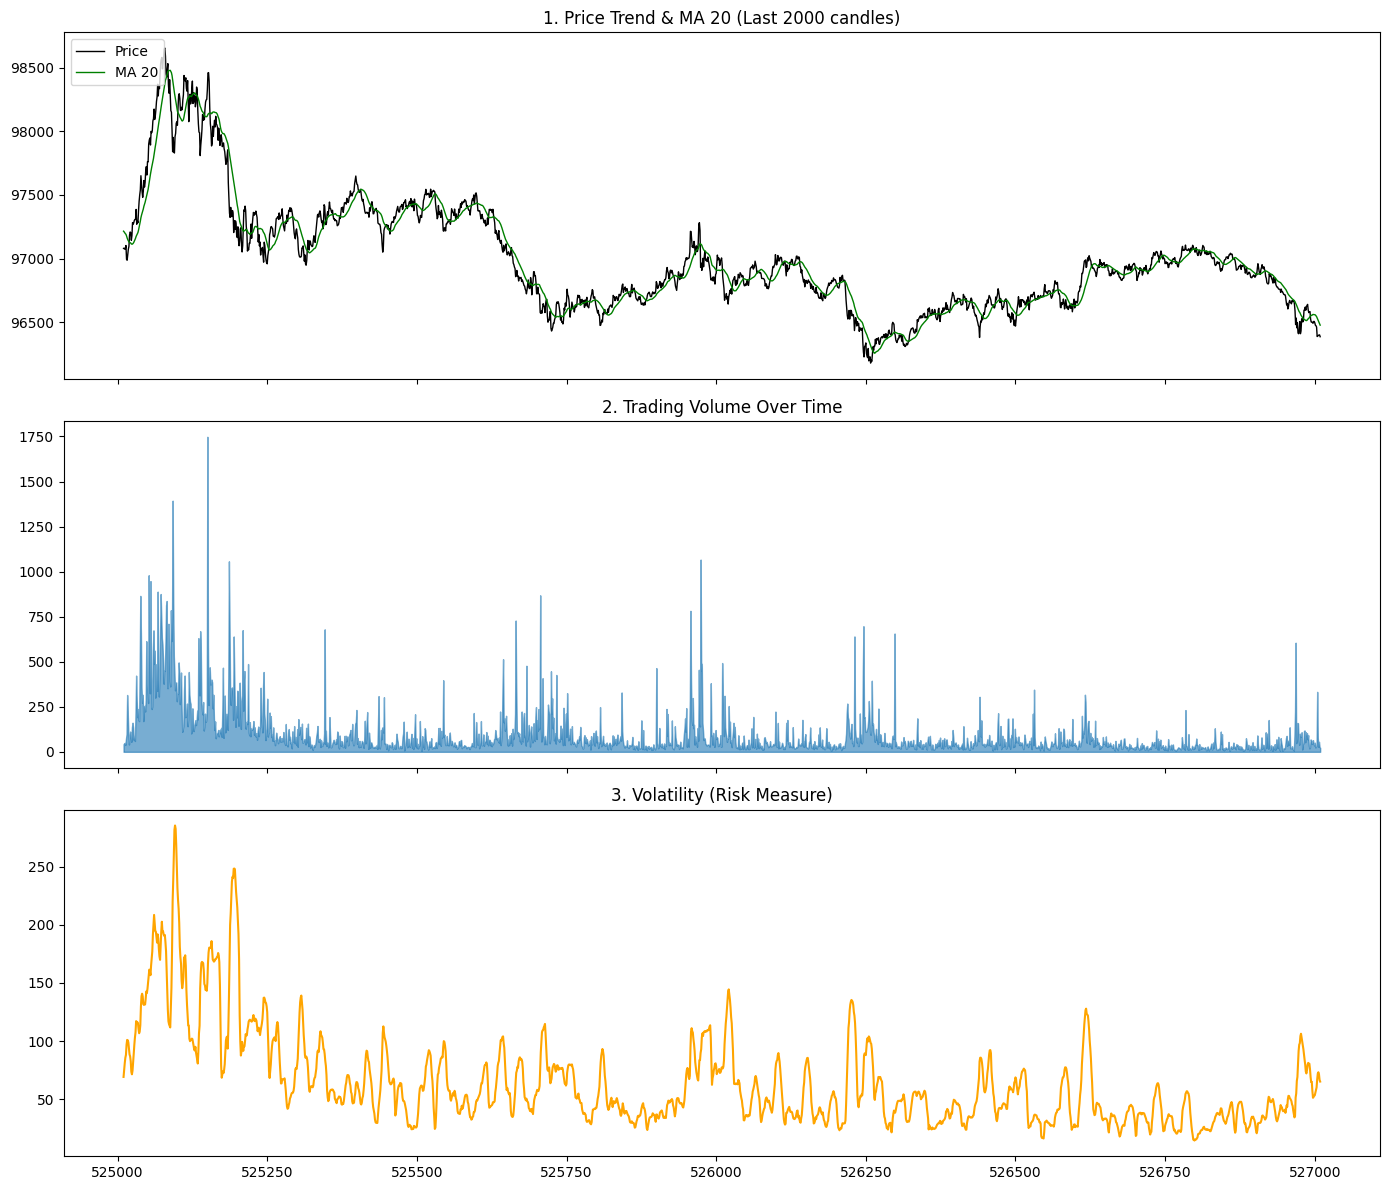

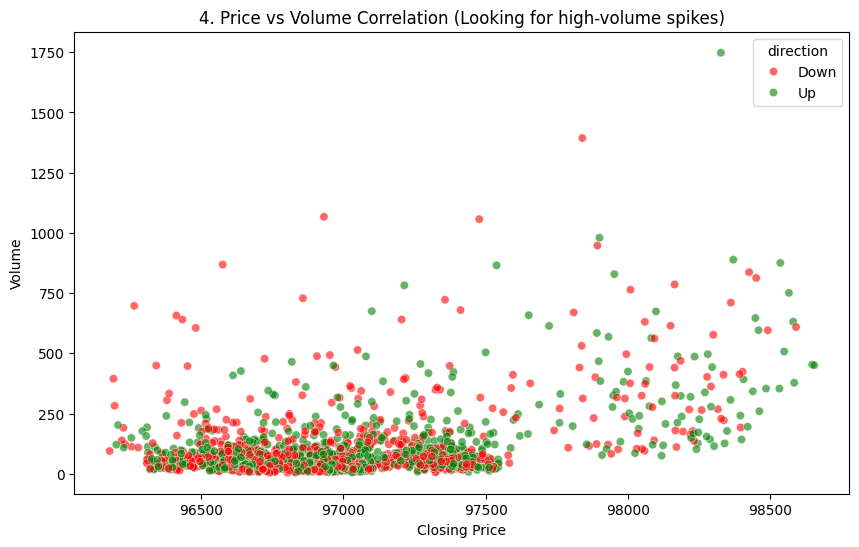

In [18]:
def plot_financial_analysis_v3(df, samples=2000):
    df_plot = df.tail(samples).copy()

    # Create a 'direction' column
    df_plot['direction'] = np.where(df_plot['price_change_pct'] >= 0, 'Up', 'Down')


    fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)


    # 1. Price Trend & Moving Average
    ax[0].plot(df_plot.index, df_plot['close'], label='Price', linewidth=1, color='black')
    ax[0].plot(df_plot.index, df_plot['ma_20'], label='MA 20', linewidth=1, color='green')
    ax[0].set_title(f'1. Price Trend & MA 20 (Last {samples} candles)')
    ax[0].legend(loc='upper left')

    # 2. Volume
    ax[1].fill_between(df_plot.index, df_plot['volume'], 0, color='#1f77b4', alpha=0.6)
    ax[1].set_title('2. Trading Volume Over Time')

    # 3. Volatility
    ax[2].plot(df_plot.index, df_plot['volatility_20'], color='orange', label='Volatility (Std Dev 20)')
    ax[2].set_title('3. Volatility (Risk Measure)')

    plt.tight_layout()
    plt.show()

    # Price vs Volume
    plt.figure(figsize=(10, 6))


    sns.scatterplot(
        data=df_plot,
        x='close',
        y='volume',
        # Color the points based on price movement (Up=Green, Down=Red)
        hue='direction',
        palette={'Up': 'green', 'Down': 'red'},
        alpha=0.6
    )

    plt.title('4. Price vs Volume Correlation (Looking for high-volume spikes)')
    plt.xlabel('Closing Price')
    plt.ylabel('Volume')
    plt.show()

    # Time Series Decomposition
    clean_close = df_plot['close'].fillna(method='ffill').dropna()
    try:
        # Use seasonal_decompose. Assuming a 30-period (monthly) cycle for seasonality check.
        res = seasonal_decompose(clean_close, model='additive', period=30)
        fig = res.plot()
        fig.set_size_inches(14, 10)
        fig.suptitle('5. Decomposition (Trend, Seasonality, Residuals/Noise)', fontsize=16)
        plt.tight_layout()
        plt.show()

    except:
        pass

# Run the analysis
plot_financial_analysis_v3(df_plot, samples=2000)

In [19]:
X = pd.concat([pd.DataFrame(X_train),
               pd.DataFrame(X_val),
               pd.DataFrame(X_test)],
              ignore_index=True)

y = pd.concat([pd.DataFrame(y_train),
               pd.DataFrame(y_val),
               pd.DataFrame(y_test)],
              ignore_index=True)

df = X.copy()
df['target'] =y

In [20]:
print('Null Values:',X.isnull().values.sum())

Null Values: 0


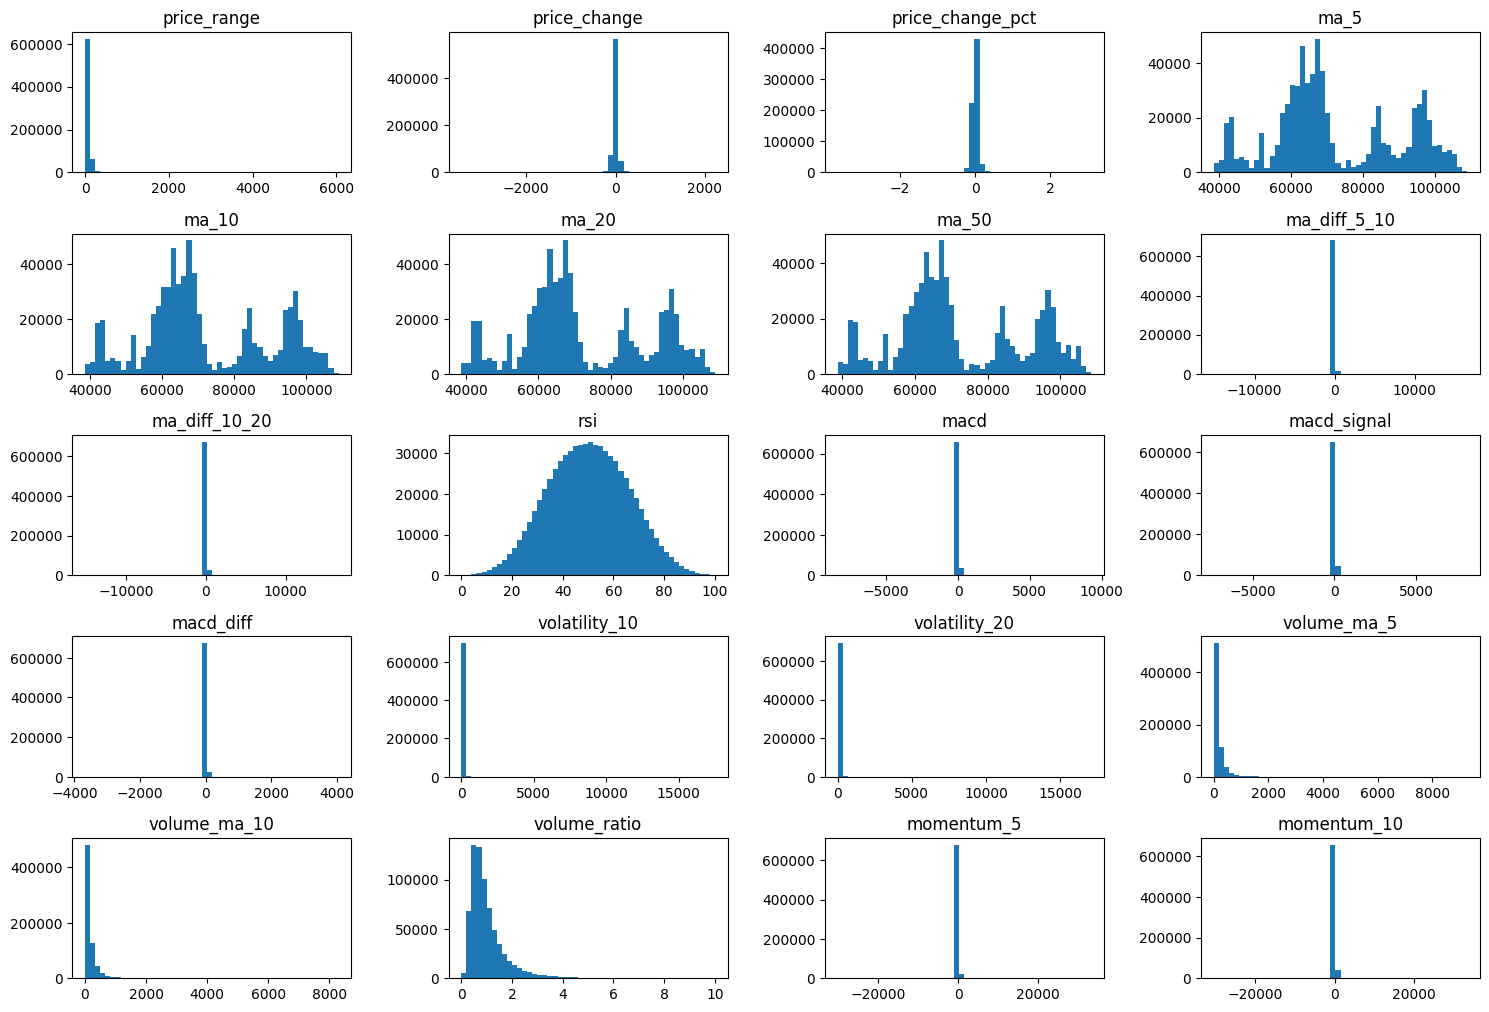

In [21]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(X.columns):
    plt.subplot((len(X.columns) // 4) + 1, 4, i + 1)
    plt.hist(df[col], bins=50)
    plt.title(col)

plt.tight_layout()
plt.show()

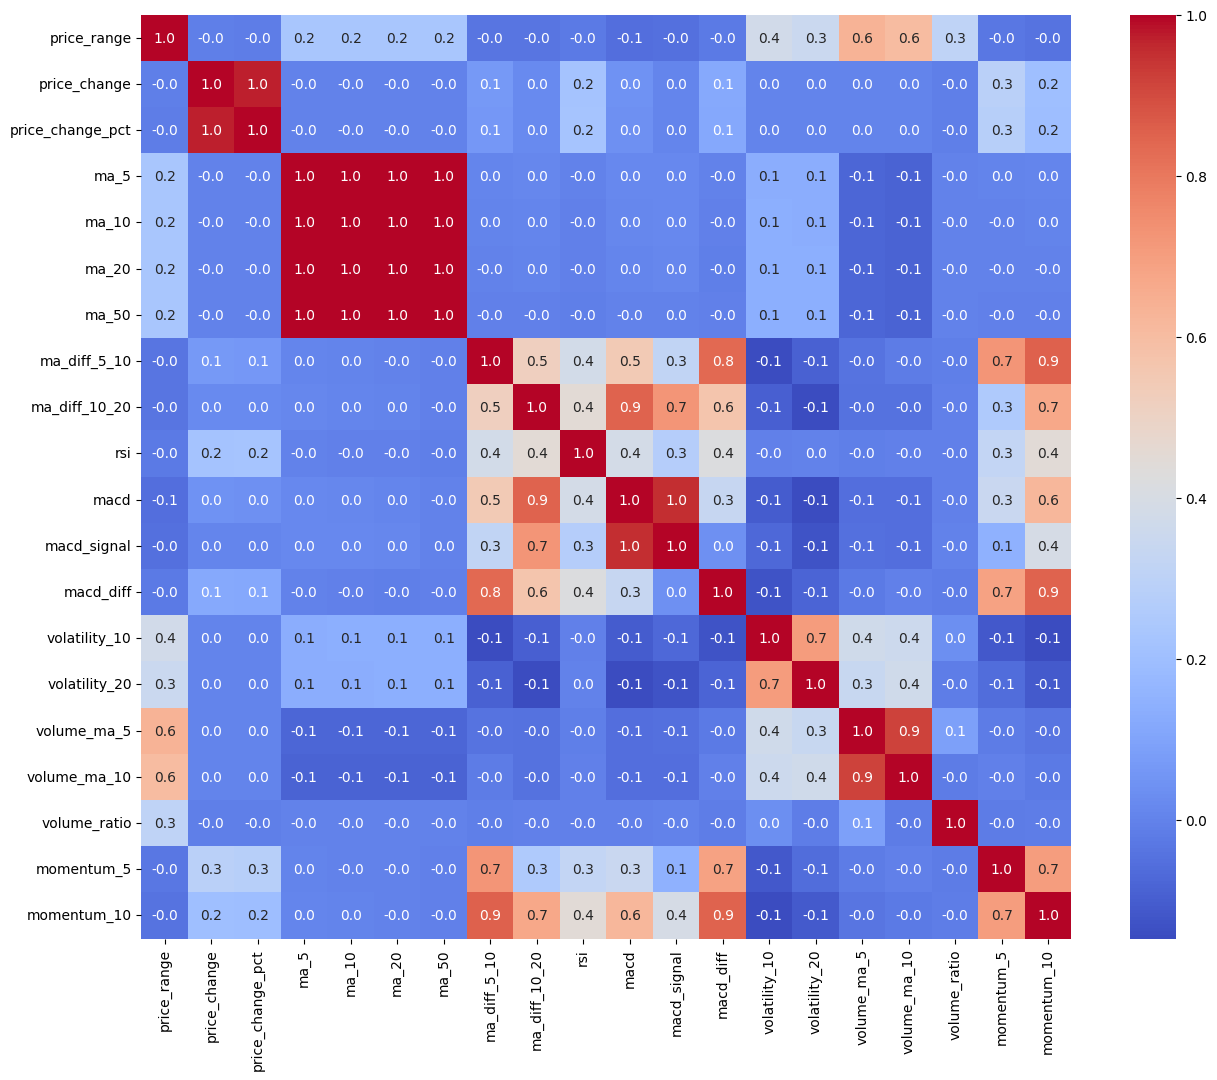

In [22]:
plt.figure(figsize=(15, 12))
sns.heatmap(X.corr(),annot=True,fmt=".1f",cmap='coolwarm')
plt.show()

The histograms indicate that several features, particularly the moving averages and momentum-based indicators, have asymmetric distributions. This behavior could be explained by the fact that price-related variables often exhibit long-tailed or clustered patterns due to market volatility and trend persistence.

The correlation matrix also shows that many features are strongly correlated with each other. This is especially noticeable among the different moving averages, which naturally track similar trends over varying time windows, as well as the MACD-related indicators, which are derived from exponential moving averages. Momentum features and MA differences also present strong relationships because they capture closely related price dynamics. Overall, these correlations are expected in technical analysis, and while they may reflect redundancy in the data, they are not inherently problematic for most machine learning models.

In [23]:
cols = [c for c in df.columns if c != 'target']

stats_up = df[df['target'] == 1][cols].agg(['mean', 'std', 'min', 'max'])
stats_down = df[df['target'] == 0][cols].agg(['mean', 'std', 'min', 'max'])

print("BTC UP ")
print(stats_up.T)
print()
print("BTC DOWN ")
print(stats_down.T)

BTC UP 
                          mean           std           min            max
price_range          61.595883     64.481381      0.000000    6051.100000
price_change         -0.818497     57.684103  -3458.200000    1704.100000
price_change_pct     -0.001143      0.078442     -3.658595       2.266739
ma_5              72095.970412  17293.780000  38586.940000  108479.280000
ma_10             72096.838615  17293.731971  38624.100000  108537.040000
ma_20             72098.209749  17293.917095  38657.650000  108706.365000
ma_50             72102.826007  17295.364605  38689.214000  108471.526000
ma_diff_5_10         -0.868203     79.289371 -11618.600000   16590.410000
ma_diff_10_20        -1.371134     99.902288 -14474.185000   13317.710000
rsi                  49.671989     15.860845      0.000000     100.000000
macd                 -2.056711     90.046210  -8155.263090    9249.312630
macd_signal          -1.993922     84.020706  -7371.574113    6643.908783
macd_diff            -0.062790

Looking at the main statistics, most features have very similar distributions between BTC up (target=1) and down (target=0) periods, with means, standard deviations, and ranges almost overlapping.

Some differences exist in features like ma_diff_5_10, ma_diff_10_20, and momentum, which slightly shift signs depending on the direction, but overall the signal is really similar.

# SVM, Decision Tree, Random Forest and XGBoost

In [24]:


def pipeline(X_train, y_train, X_val, y_val, X_test, y_test, model, matrix=True):
    # Training
    final_model = make_pipeline(StandardScaler(), model)
    final_model.fit(X_train, y_train)

    # Pred
    train_pred = final_model.predict(X_train)
    val_pred = final_model.predict(X_val)
    test_pred = final_model.predict(X_test)

    # Metrics
    accuracy_train = accuracy_score(y_train, train_pred)
    accuracy_test = accuracy_score(y_test, test_pred)
    accuracy_val = accuracy_score(y_val, val_pred)
    accuracy = [accuracy_train, accuracy_test, accuracy_val]

    precision_train = precision_score(y_train, train_pred)
    precision_test = precision_score(y_test, test_pred)
    precision_val = precision_score(y_val, val_pred)
    precision = [precision_train, precision_test, precision_val]

    recall_train = recall_score(y_train, train_pred)
    recall_test = recall_score(y_test, test_pred)
    recall_val = recall_score(y_val, val_pred)
    recall = [recall_train, recall_test, recall_val]

    f1_train = f1_score(y_train, train_pred)
    f1_test = f1_score(y_test, test_pred)
    f1_val = f1_score(y_val, val_pred)
    f1 = [f1_train, f1_test, f1_val]

    # Confusion Matrix
    matrix_train = confusion_matrix(y_train, train_pred)
    matrix_test = confusion_matrix(y_test, test_pred)
    matrix_val = confusion_matrix(y_val, val_pred)
    matrix = [matrix_train, matrix_test, matrix_val]

    # Results
    print(f"            Evaluation results: {type(model).__name__}            ")
    print()
    print('TRAIN SET')
    print("Accuracy  : ", accuracy_train)
    print("Precision : ", precision_train)
    print("Recall    : ", recall_train)
    print("F1        : ", f1_train)
    print()
    print('VALIDATION SET')
    print("Accuracy  : ", accuracy_val)
    print("Precision : ", precision_val)
    print("Recall    : ", recall_val)
    print("F1        : ", f1_val)
    print()
    print('TEST SET')
    print("Accuracy  : ", accuracy_test)
    print("Precision : ", precision_test)
    print("Recall    : ", recall_test)
    print("F1        : ", f1_test)

    if matrix :
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Train
        disp_train = ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=[0, 1])
        disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
        axes[0].set_title("Train Confusion Matrix")

        # Validation
        disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
        disp_val.plot(ax=axes[1], cmap='Blues', values_format='d')
        axes[1].set_title("Validation Confusion Matrix")

        # Test
        disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
        disp_test.plot(ax=axes[2], cmap='Blues', values_format='d')
        axes[2].set_title("Test Confusion Matrix")

        plt.tight_layout()
        plt.show()

    return accuracy, precision, recall, f1, matrix, model

This initial phase aims to establish a reference performance (benchmark) for each model family (Tree-based, Linear, etc.).

To ensure honest and comparable results:
1.  We are using simple and moderate hyperparameter (e.g., restricted max_depth, moderate n_estimators).
2.  This serves as a preventative regularization strategy, avoiding immediate, trivial overfitting on the training set, which would yield artificially high and non-representative scores.
3.  These models will serve as critical reference points to judge the true value-add of our subsequent Optimized Model.

            Evaluation results: DecisionTreeClassifier            

TRAIN SET
Accuracy  :  0.523102501276355
Precision :  0.5242243820803295
Recall    :  0.6116052822282382
F1        :  0.5645536672056176

VALIDATION SET
Accuracy  :  0.5308930134434544
Precision :  0.5329009212257944
Recall    :  0.5083848982154067
F1        :  0.520354307219239

TEST SET
Accuracy  :  0.5118713938835581
Precision :  0.5149198809085739
Recall    :  0.4787416023886539
F1        :  0.49617213312918046


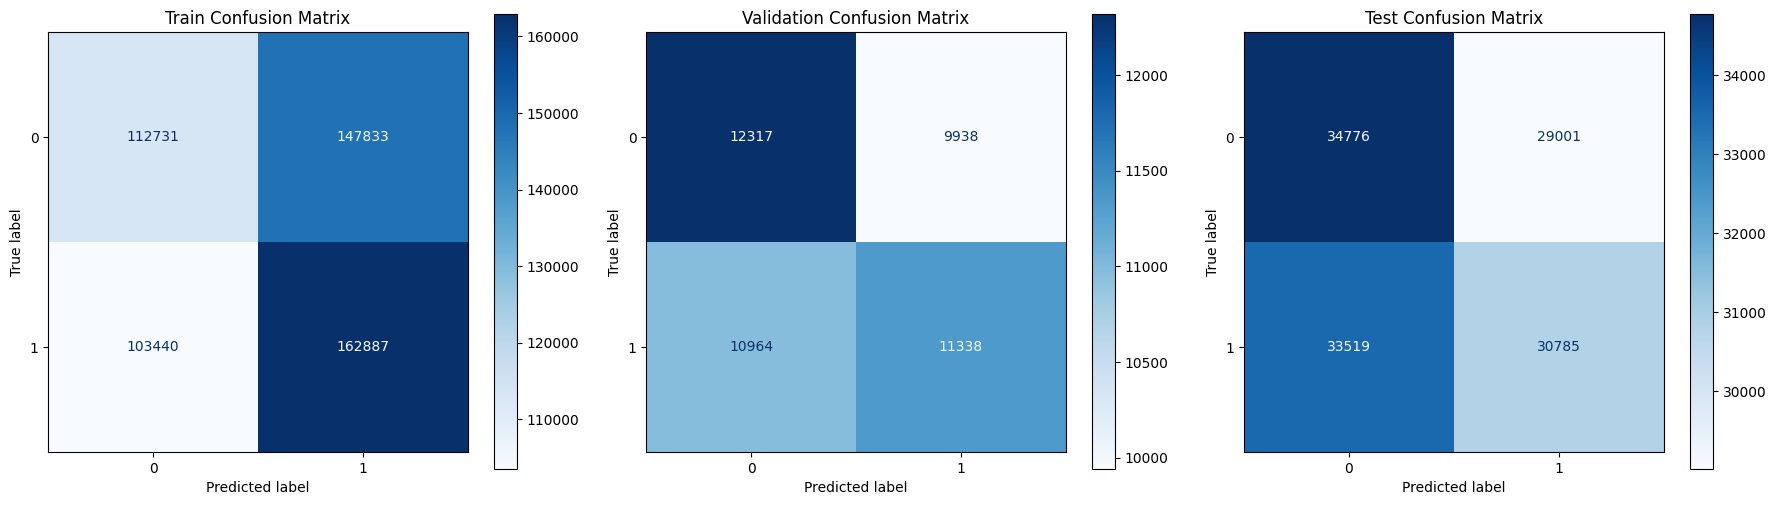

            Evaluation results: RandomForestClassifier            

TRAIN SET
Accuracy  :  0.5899854049509291
Precision :  0.5890676357248101
Recall    :  0.6244766771675422
F1        :  0.6062555703592187

VALIDATION SET
Accuracy  :  0.5215566577642121
Precision :  0.5238302818947981
Recall    :  0.4849340866290019
F1        :  0.503632299525007

TEST SET
Accuracy  :  0.5123320398810128
Precision :  0.5131389463178156
Recall    :  0.5596696939537198
F1        :  0.5353952350136493


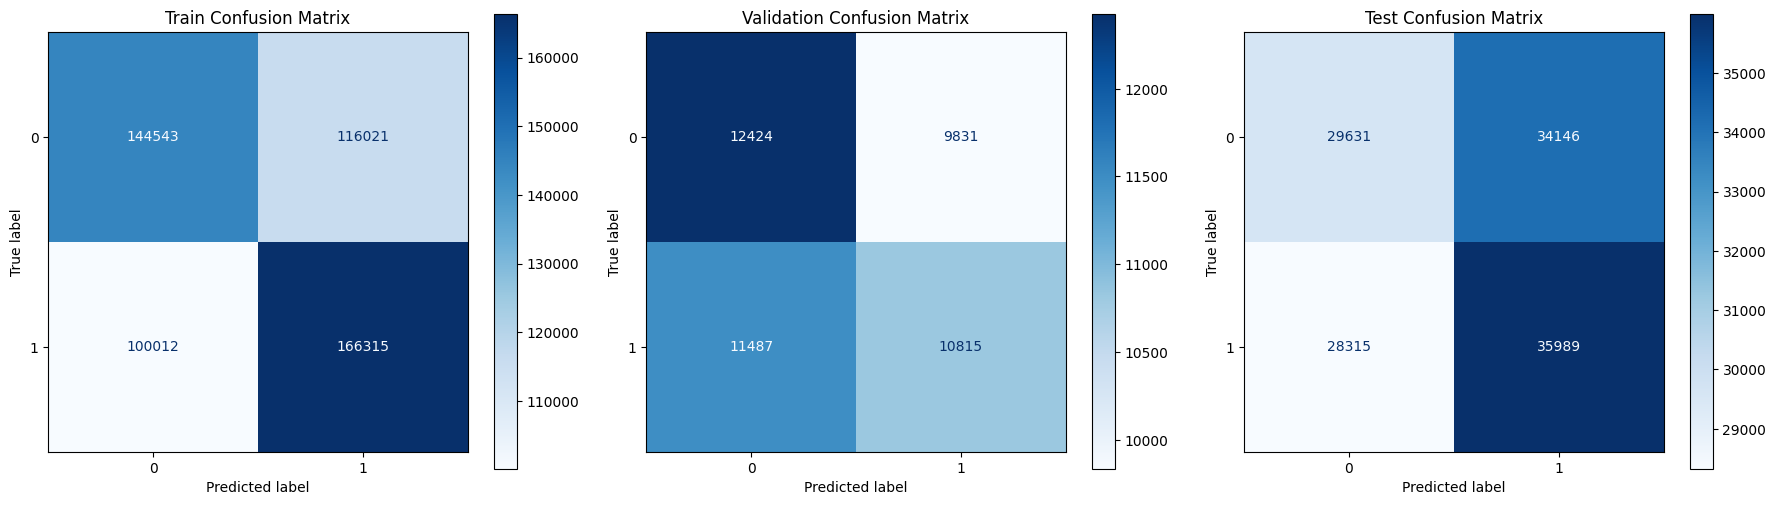

            Evaluation results: XGBClassifier            

TRAIN SET
Accuracy  :  0.5858725998356397
Precision :  0.5841754905150189
Recall    :  0.6270487032858103
F1        :  0.6048533140166606

VALIDATION SET
Accuracy  :  0.5136342213344705
Precision :  0.5144400201382214
Recall    :  0.503990673482199
F1        :  0.5091617403909311

TEST SET
Accuracy  :  0.5099819645380658
Precision :  0.5080329235257345
Recall    :  0.758288753421249
F1        :  0.608432532255247


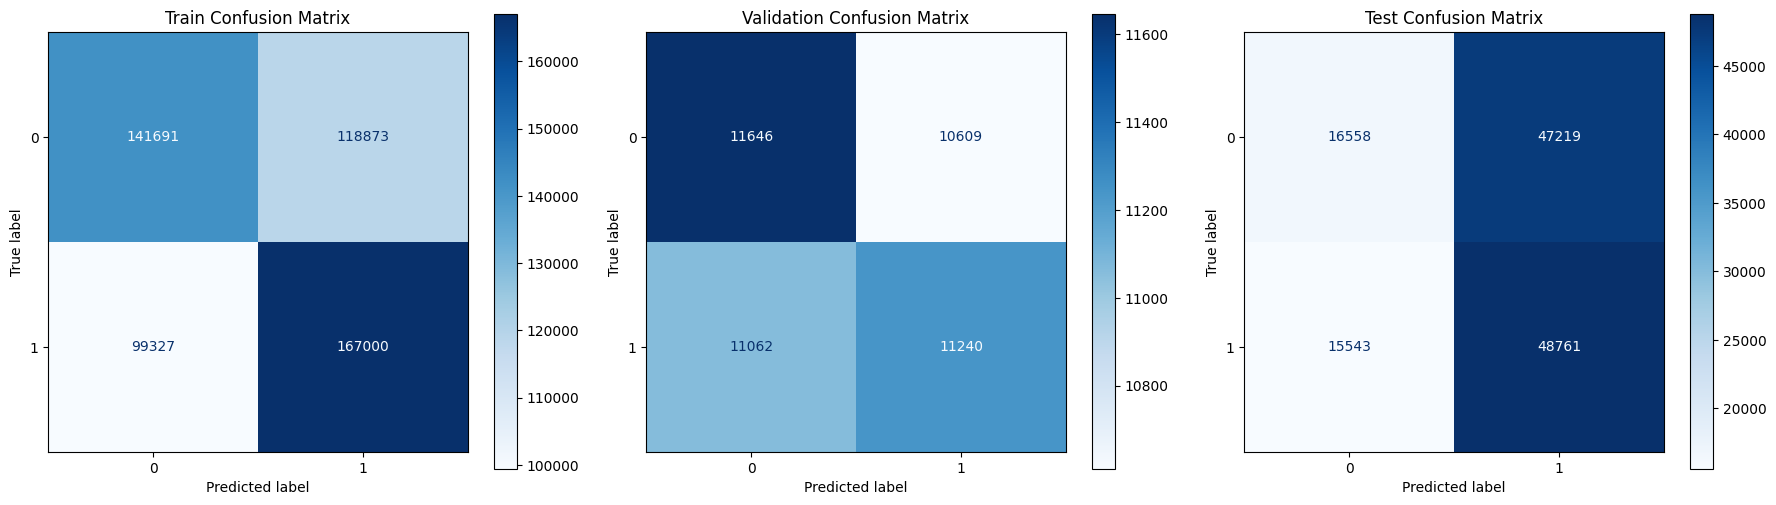

            Evaluation results: SGDClassifier            

TRAIN SET
Accuracy  :  0.5146149772913183
Precision :  0.5148376024274104
Recall    :  0.6893330379570979
F1        :  0.5894423209363627

VALIDATION SET
Accuracy  :  0.5129609264537559
Precision :  0.5543301392153318
Recall    :  0.1374764595103578
F1        :  0.2203140157367154

TEST SET
Accuracy  :  0.5079910369219478
Precision :  0.5172524732566557
Recall    :  0.3000279920378204
F1        :  0.37977225081936555


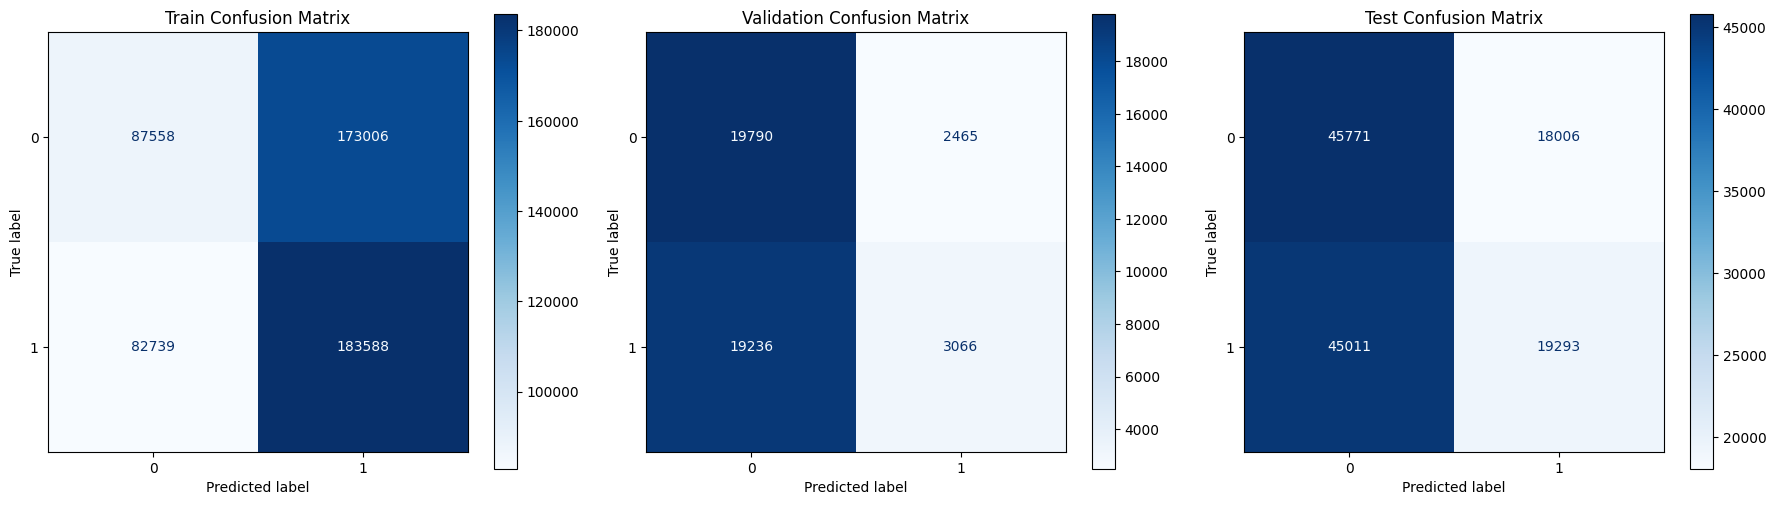

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier  # Pour le benchmark SVM rapide
import xgboost as xgb
from xgboost import XGBClassifier

# 1. DECISION TREE
accuracy_decisiontree, precision_decisiontree, recally_decisiontree, f1y_decisiontree, matrixy_decisiontree, modely_decisiontree = pipeline(
    X_train, y_train, X_val, y_val, X_test, y_test,
    DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, random_state=42)
)

# 2. RANDOM FOREST
accuracy_randomForest, precision_randomForest, recall_randomForest, f1_randomForest, matrix_randomForest, model_randomForest = pipeline(
    X_train, y_train, X_val, y_val, X_test, y_test,
    RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
)

# 3. XGBOOST

accuracy_XGBOOST, precision_XGBOOST, recall_XGBOOST, f1_XGBOOST, matrix_XGBOOST, model_XGBOOST = pipeline(
    X_train, y_train, X_val, y_val, X_test, y_test,
    xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1
    )
)

#  4. SVM
accuracy_SVM, precision_SVM, recall_SVM, f1_SVM, matrix_SVM, model_SVM = pipeline(
    X_train, y_train, X_val, y_val, X_test, y_test,
    SGDClassifier(
        loss='hinge',
        alpha=0.0001,
        max_iter=1000,
        tol=1e-3,
        random_state=42
    )
)

COMPREHENSIVE MODEL COMPARISON
                          Accuracy  F1-Score  Precision    Recall
Model         Dataset                                            
Decision Tree Test        0.511871  0.496172   0.514920  0.478742
              Train       0.523103  0.564554   0.524224  0.611605
              Validation  0.530893  0.520354   0.532901  0.508385
Random Forest Test        0.512332  0.535395   0.513139  0.559670
              Train       0.589985  0.606256   0.589068  0.624477
              Validation  0.521557  0.503632   0.523830  0.484934
SVM           Test        0.507991  0.379772   0.517252  0.300028
              Train       0.514615  0.589442   0.514838  0.689333
              Validation  0.512961  0.220314   0.554330  0.137476
XGBoost       Test        0.509982  0.608433   0.508033  0.758289
              Train       0.585873  0.604853   0.584175  0.627049
              Validation  0.513634  0.509162   0.514440  0.503991


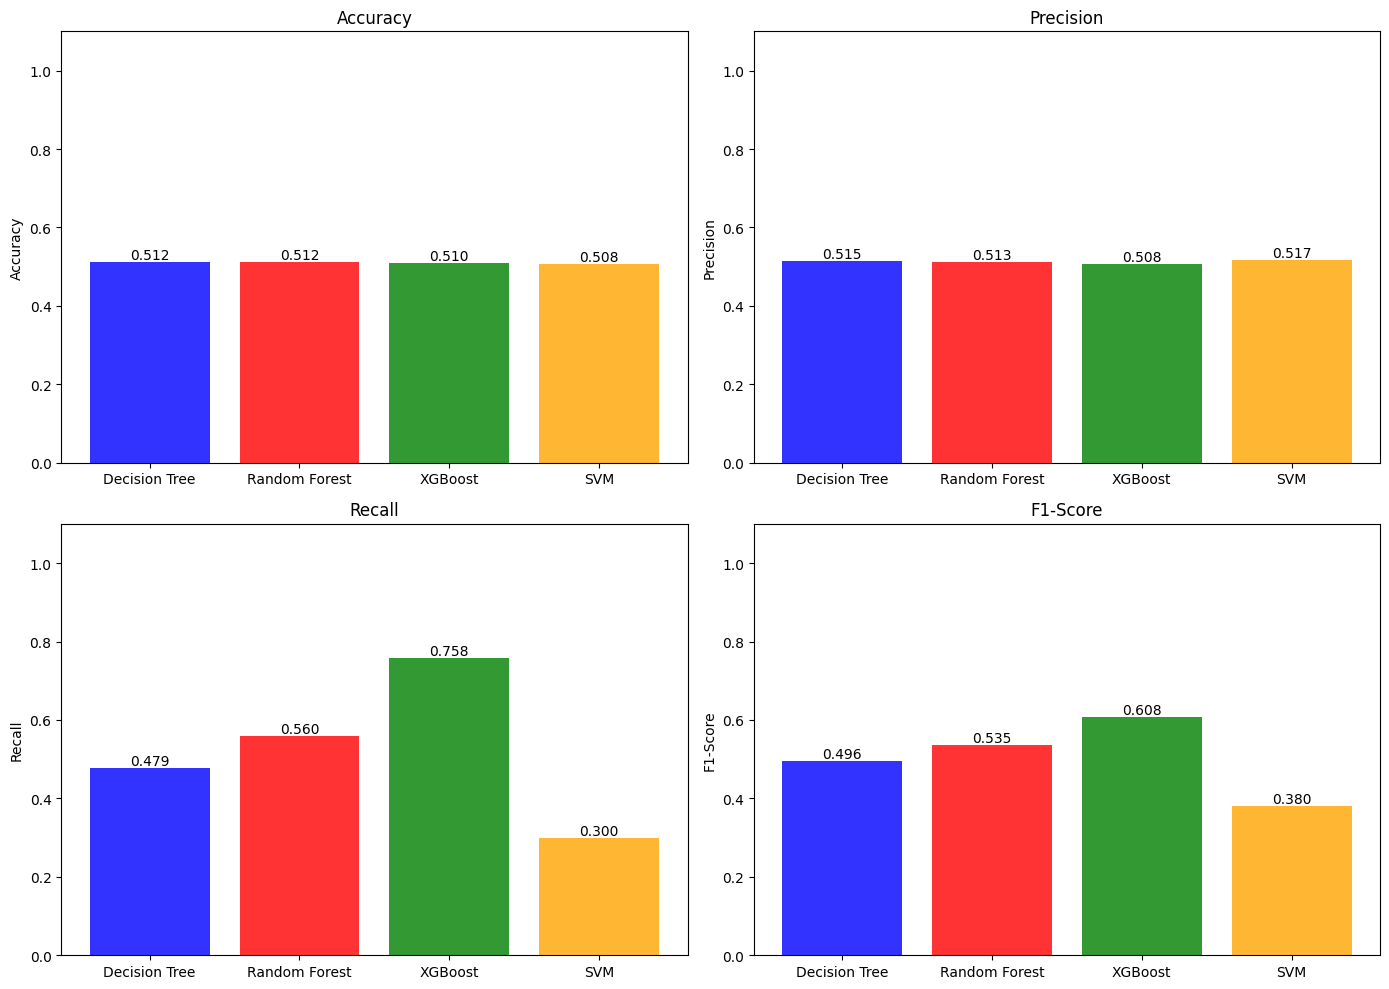


TEST SET PERFORMANCE
        Model  Accuracy  Precision   Recall  F1-Score
Decision Tree  0.511871   0.514920 0.478742  0.496172
Random Forest  0.512332   0.513139 0.559670  0.535395
      XGBoost  0.509982   0.508033 0.758289  0.608433
          SVM  0.507991   0.517252 0.300028  0.379772

BEST MODEL PER METRIC
Accuracy: Random Forest (0.5123)
Precision: SVM (0.5173)
Recall: XGBoost (0.7583)
F1-Score: XGBoost (0.6084)

Baseline (Majority Class): 0.5021

IMPROVEMENT OVER BASELINE
Decision Tree: 0.5119 (+0.0098)
Random Forest: 0.5123 (+0.0103)
XGBoost: 0.5100 (+0.0079)
SVM: 0.5080 (+0.0059)


In [26]:
results = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models_data = [
    ('Decision Tree', accuracy_decisiontree, precision_decisiontree, recally_decisiontree, f1y_decisiontree),
    ('Random Forest', accuracy_randomForest, precision_randomForest, recall_randomForest, f1_randomForest),
    ('XGBoost', accuracy_XGBOOST, precision_XGBOOST, recall_XGBOOST, f1_XGBOOST),
    ('SVM', accuracy_SVM, precision_SVM, recall_SVM, f1_SVM)
]

datasets = ['Train', 'Test', 'Validation']

for model_name, acc, prec, rec, f1 in models_data:
    for i, dataset in enumerate(datasets):
        results['Model'].append(model_name)
        results['Dataset'].append(dataset)
        results['Accuracy'].append(acc[i])
        results['Precision'].append(prec[i])
        results['Recall'].append(rec[i])
        results['F1-Score'].append(f1[i])

df_results = pd.DataFrame(results)
df_pivot = df_results.pivot_table(index=['Model', 'Dataset'], values=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("COMPREHENSIVE MODEL COMPARISON")
print(df_pivot)

df_test = df_results[df_results['Dataset'] == 'Test'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    models = df_test['Model'].values
    values = df_test[metric].values
    bars = ax.bar(models, values, color=['blue', 'red', 'green','orange'], alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nTEST SET PERFORMANCE")
print(df_test[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nBEST MODEL PER METRIC")
for metric in metrics:
    best_idx = df_test[metric].idxmax()
    best_model = df_test.loc[best_idx, 'Model']
    best_value = df_test.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nBaseline (Majority Class): {baseline:.4f}")
print("\nIMPROVEMENT OVER BASELINE")
for _, row in df_test.iterrows():
    improvement = row['Accuracy'] - baseline
    print(f"{row['Model']}: {row['Accuracy']:.4f} (+{improvement:.4f})")

Across all architectures, the Test set accuracy hovers strictly between $50.8\%$ and $51.2\%$. In the context of financial markets, this indicates that the models are performing essentially as a random coin flip, struggling to extract a statistically significant signal from the noise.

The ensemble models exhibit clear signs of overfitting. We observe a significant divergence between Training accuracy ($\approx 59\%$) and Test accuracy ($\approx 51\%$). This generalization gap suggests that these models are memorizing stochastic noise within the 2024 training data rather than learning robust market drivers applicable to 2025.A specific behavioral anomaly is observed in the XGBoost baseline. While it achieves the highest F1-Score ($0.608$), this is driven by a disproportionately high Recall ($0.758$) paired with low Precision ($0.508$). This indicates a "permissive" bias: the model effectively "spams" the Buy signal (predicting 'UP' constantly). While this strategy captures most upward trends, the high rate of False Positives would likely result in net financial losses.


Conversely, the Decision Tree demonstrates signs of underfitting. The Training accuracy ($52.3\%$) is barely superior to the Test accuracy ($51.2\%$). Even on the data it studied, the model failed to identify predictive patterns, constrained by the regularization parameters (depth and leaf size) applied to establish the baseline.

The SVM (SGD Classifier) adopts the opposite strategy to XGBoost. With a Test Recall of only $0.300$, this model is overly conservative, predicting the negative class ('DOWN') for the vast majority of instances. While this slightly improves Precision ($0.517$), the model fails to trigger on most trading opportunities, rendering it ineffective for active trading strategies.

# New features

In [27]:
def add_extra_features(df):
    df = df.copy()

    # Time features
    df['hour_of_day'] = df['open_time'].dt.hour
    df['day_of_week'] = df['open_time'].dt.dayofweek

    # Ratio features
    df['price_vs_ma20'] = df['close'] / df['ma_20']
    df['ma5_vs_ma20'] = df['ma_5'] / df['ma_20']

    # Momentum change features
    df['rsi_change'] = df['rsi'].diff(periods=3)


    return df

def process_pipeline(df_input):
    df = create_features(df_input)
    df = add_extra_features(df)

    df['future_close'] = df['close'].shift(-30)
    df['target'] = (df['future_close'] > df['close']).astype(int)
    df.loc[df['future_close'].isna(), 'target'] = np.nan
    df.dropna(inplace=True)

    y = df['target'].astype(int)

    cols_to_drop = [
        'close_time', 'open_time', 'open', 'high', 'low', 'close', 'volume',
        'target', 'future_close'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]

    X = df.drop(columns=cols_to_drop)

    return X, y




train['open_time'] = pd.to_datetime(train['open_time'], unit='ms')
val['open_time'] = pd.to_datetime(val['open_time'], unit='ms')
test['open_time'] = pd.to_datetime(test['open_time'], unit='ms')


X_train_nf, y_train_nf = process_pipeline(train)
X_val_nf, y_val_nf = process_pipeline(val)
X_test_nf, y_test_nf = process_pipeline(test)

print(f"\nTrain shape: {X_train_nf.shape}")
print(f"Val shape: {X_val_nf.shape}")
print(f"Test shape: {X_test_nf.shape}")
print("\nFeatures finales:", X_train_nf.columns.tolist())


Train shape: (526887, 25)
Val shape: (44557, 25)
Test shape: (128081, 25)

Features finales: ['price_range', 'price_change', 'price_change_pct', 'ma_5', 'ma_10', 'ma_20', 'ma_50', 'ma_diff_5_10', 'ma_diff_10_20', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'volatility_10', 'volatility_20', 'volume_ma_5', 'volume_ma_10', 'volume_ratio', 'momentum_5', 'momentum_10', 'hour_of_day', 'day_of_week', 'price_vs_ma20', 'ma5_vs_ma20', 'rsi_change']


**1. Time-Based Features**
These capture when the trading occurred, allowing the model to detect daily or weekly patterns.

hour_of_day: The hour the candle opened.

day_of_week: The day of the week (0-6).

**2. Ratio/Crossover Features**
These measure the relative position of price and moving averages, indicating trend strength.

price_vs_ma20: Current price relative to the 20-period Moving Average.

ma5_vs_ma20: Short-term MA (5) relative to the long-term MA (20).

**3. Momentum Change Feature**
This tracks the acceleration or deceleration of market momentum.

rsi_change: The change in the Relative Strength Index (RSI) over the last 3 periods.

# Improvement over the Baseline model

            Evaluation results: XGBClassifier            

TRAIN SET
Accuracy  :  0.6057636646947069
Precision :  0.6019397886270499
Recall    :  0.6496973611090251
F1        :  0.6249074538894648

VALIDATION SET
Accuracy  :  0.5108512691608501
Precision :  0.5117693486234273
Recall    :  0.49426060443009595
F1        :  0.5028626171848269

TEST SET
Accuracy  :  0.51489291932449
Precision :  0.511530576475712
Recall    :  0.7488803184871858
F1        :  0.6078576162075168


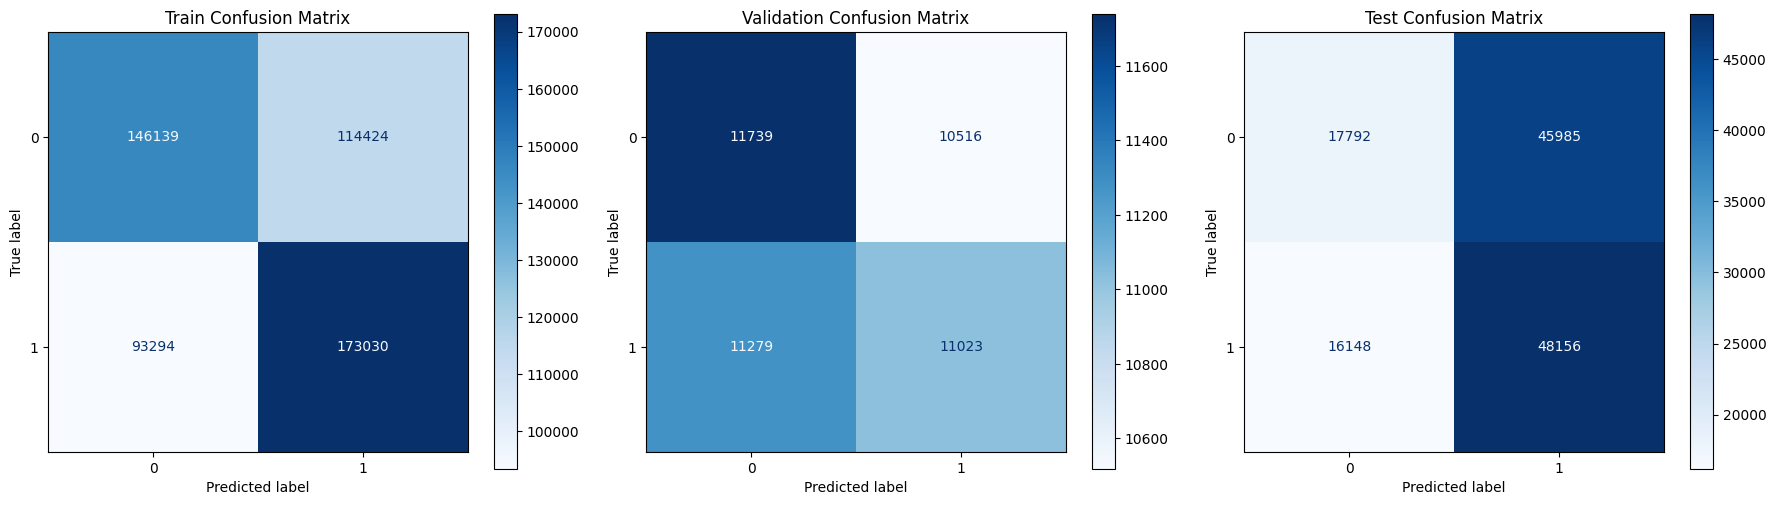

In [28]:
accuracy_XGBOOST_2, precision_XGBOOST_2, recall_XGBOOST_2, f1_XGBOOST_2, matrix_XGBOOST_2, model_XGBOOST_2 = pipeline(
    X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf,
    xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1
    ),matrix=False
)

COMPREHENSIVE MODEL COMPARISON
                                 Accuracy  F1-Score  Precision    Recall
Model                Dataset                                            
XGBoost              Test        0.509982  0.608433   0.508033  0.758289
                     Train       0.585873  0.604853   0.584175  0.627049
                     Validation  0.513634  0.509162   0.514440  0.503991
XGBoost new features Test        0.514893  0.607858   0.511531  0.748880
                     Train       0.605764  0.624907   0.601940  0.649697
                     Validation  0.510851  0.502863   0.511769  0.494261


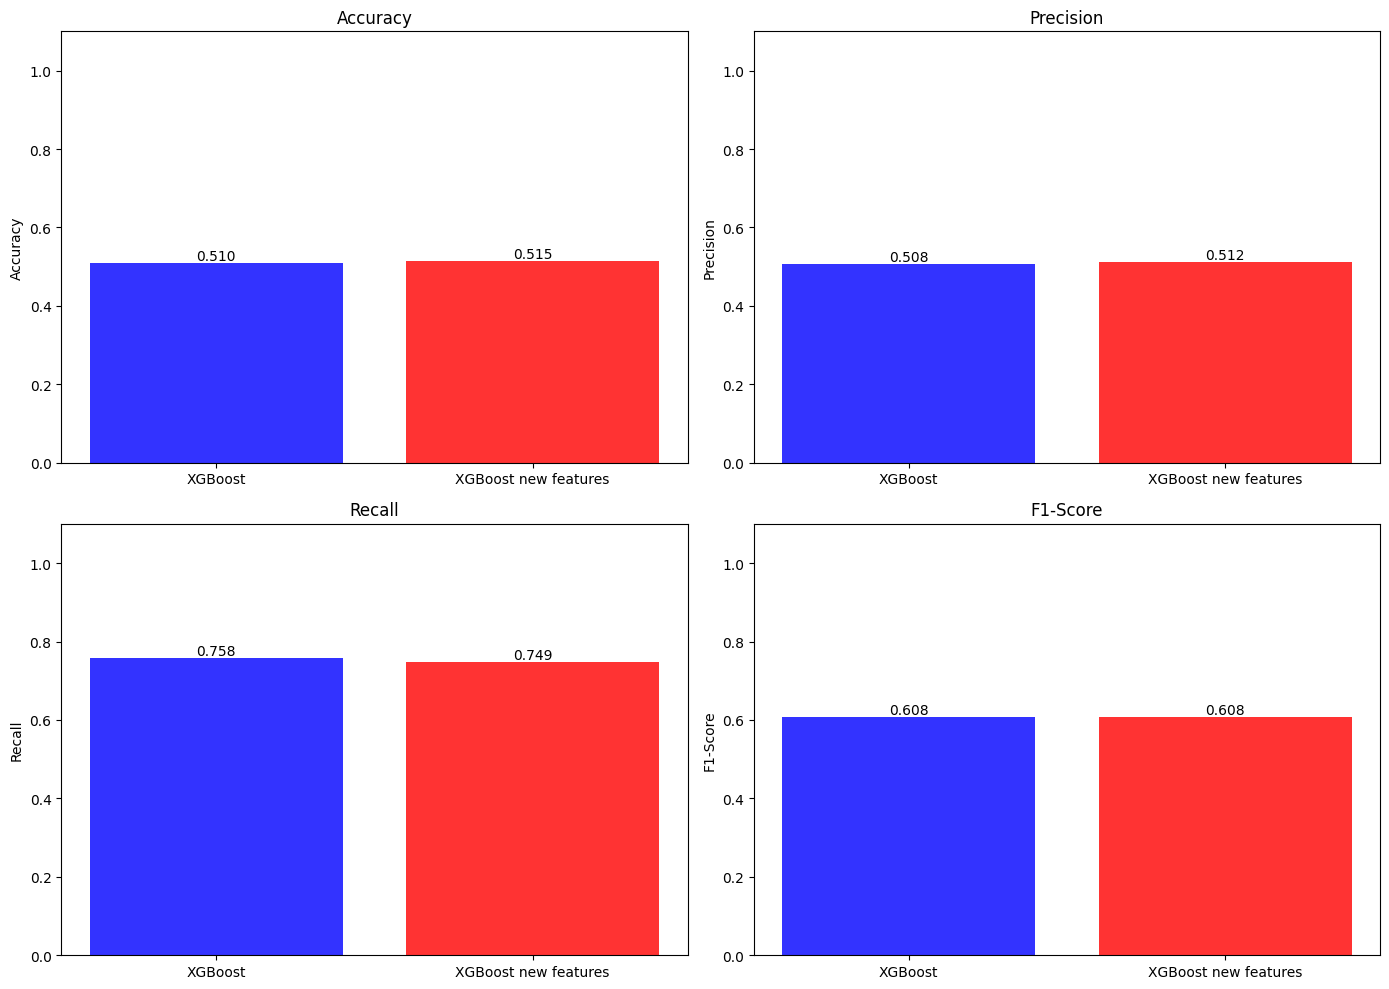


TEST SET PERFORMANCE
               Model  Accuracy  Precision   Recall  F1-Score
             XGBoost  0.509982   0.508033 0.758289  0.608433
XGBoost new features  0.514893   0.511531 0.748880  0.607858

BEST MODEL PER METRIC
Accuracy: XGBoost new features (0.5149)
Precision: XGBoost new features (0.5115)
Recall: XGBoost (0.7583)
F1-Score: XGBoost (0.6084)

Baseline (Majority Class): 0.5021

IMPROVEMENT OVER BASELINE
XGBoost: 0.5100 (+0.0079)
XGBoost new features: 0.5149 (+0.0128)


In [29]:

results = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models_data = [
    ('XGBoost', accuracy_XGBOOST, precision_XGBOOST, recall_XGBOOST, f1_XGBOOST),
    ('XGBoost new features', accuracy_XGBOOST_2, precision_XGBOOST_2, recall_XGBOOST_2, f1_XGBOOST_2),

]

datasets = ['Train', 'Test', 'Validation']

for model_name, acc, prec, rec, f1 in models_data:
    for i, dataset in enumerate(datasets):
        results['Model'].append(model_name)
        results['Dataset'].append(dataset)
        results['Accuracy'].append(acc[i])
        results['Precision'].append(prec[i])
        results['Recall'].append(rec[i])
        results['F1-Score'].append(f1[i])

df_results = pd.DataFrame(results)
df_pivot = df_results.pivot_table(index=['Model', 'Dataset'], values=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("COMPREHENSIVE MODEL COMPARISON")
print(df_pivot)

df_test = df_results[df_results['Dataset'] == 'Test'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    models = df_test['Model'].values
    values = df_test[metric].values
    bars = ax.bar(models, values, color=['blue', 'red'], alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nTEST SET PERFORMANCE")
print(df_test[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nBEST MODEL PER METRIC")
for metric in metrics:
    best_idx = df_test[metric].idxmax()
    best_model = df_test.loc[best_idx, 'Model']
    best_value = df_test.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nBaseline (Majority Class): {baseline:.4f}")
print("\nIMPROVEMENT OVER BASELINE")
for _, row in df_test.iterrows():
    improvement = row['Accuracy'] - baseline
    print(f"{row['Model']}: {row['Accuracy']:.4f} (+{improvement:.4f})")

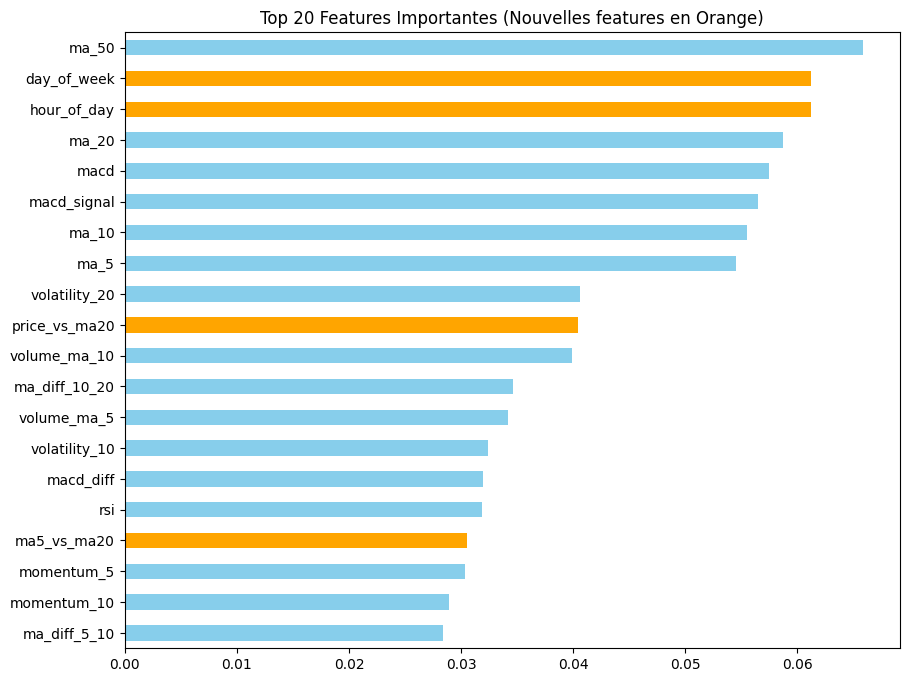

In [30]:
importances = pd.Series(model_XGBOOST_2.feature_importances_, index=X_train_nf.columns)
top_20 = importances.sort_values(ascending=True).tail(20)

plt.figure(figsize=(10, 8))
# New features
new_cols = ['hour_of_day', 'day_of_week', 'price_vs_ma20', 'ma5_vs_ma20', 'rsi_change', 'macd_change']
colors = ['orange' if col in new_cols else 'skyblue' for col in top_20.index]

top_20.plot(kind='barh', color=colors)
plt.title('Top 20 Features Importantes')
plt.show()

Features sélectionnées (20) :
['ma_diff_5_10', 'momentum_10', 'momentum_5', 'ma5_vs_ma20', 'rsi', 'macd_diff', 'volatility_10', 'volume_ma_5', 'ma_diff_10_20', 'volume_ma_10', 'price_vs_ma20', 'volatility_20', 'ma_5', 'ma_10', 'macd_signal', 'macd', 'ma_20', 'hour_of_day', 'day_of_week', 'ma_50']

Entraînement du modèle optimisé (Feature Selection)...
            Evaluation results: XGBClassifier            

TRAIN SET
Accuracy  :  0.6101156414942862
Precision :  0.6066745374733309
Recall    :  0.6502267914269837
F1        :  0.6276961108583877

VALIDATION SET
Accuracy  :  0.5161254123931145
Precision :  0.5173737941369299
Recall    :  0.49538158012734285
F1        :  0.5061389041597948

TEST SET
Accuracy  :  0.5123554625588495
Precision :  0.5098371488255105
Recall    :  0.7439195073401343
F1        :  0.6050261806591961


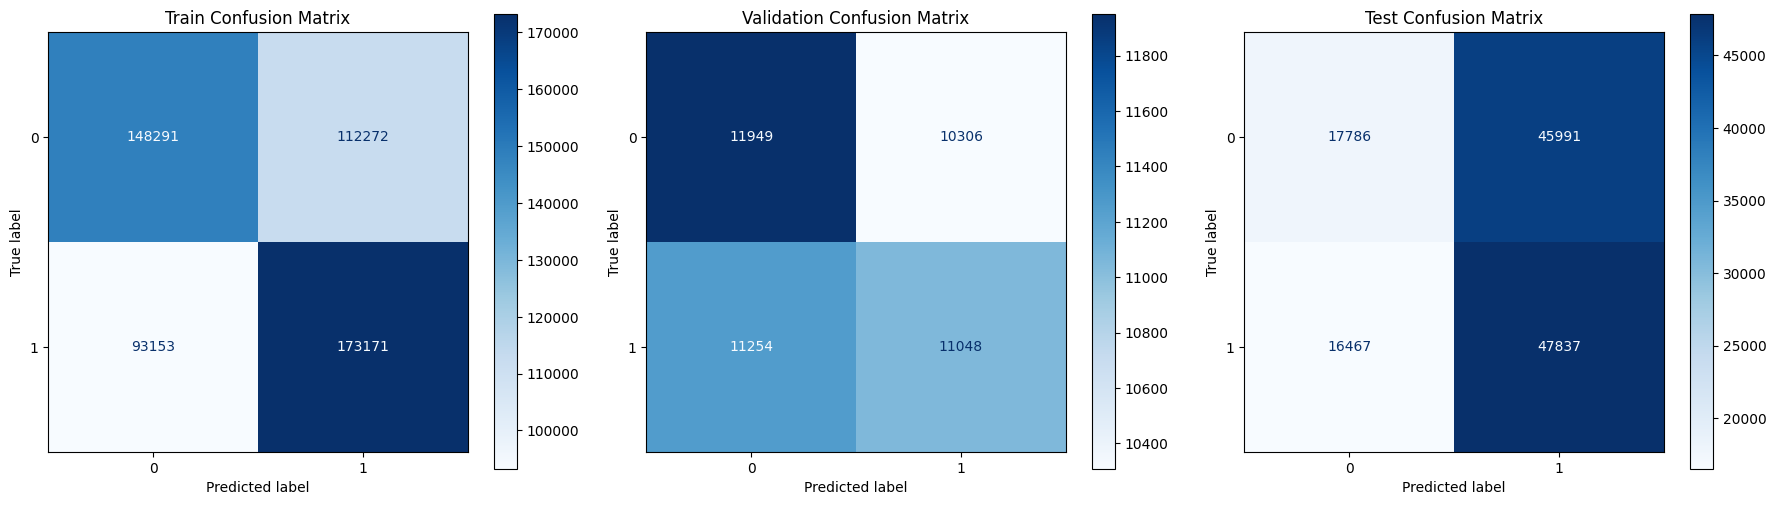

In [31]:
# 20 best features
selected_features = top_20.index.tolist()

print(f"Features selected ({len(selected_features)}) :")
print(selected_features)

X_train_opt = X_train_nf[selected_features]
X_val_opt = X_val_nf[selected_features]
X_test_opt = X_test_nf[selected_features]

# Training
accuracy_XGBOOST_20, precision_XGBOOST_20, recall_XGBOOST_20, f1_XGBOOST_20, matrix_XGBOOST_20, model_XGBOOST_20 = pipeline(
    X_train_opt, y_train_nf, X_val_opt, y_val_nf, X_test_opt, y_test_nf,
    xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1
    )
)



COMPREHENSIVE MODEL COMPARISON
                                 Accuracy  F1-Score  Precision    Recall
Model                Dataset                                            
XGBoost              Test        0.509982  0.608433   0.508033  0.758289
                     Train       0.585873  0.604853   0.584175  0.627049
                     Validation  0.513634  0.509162   0.514440  0.503991
XGBoost 20 features  Test        0.512355  0.605026   0.509837  0.743920
                     Train       0.610116  0.627696   0.606675  0.650227
                     Validation  0.516125  0.506139   0.517374  0.495382
XGBoost new features Test        0.514893  0.607858   0.511531  0.748880
                     Train       0.605764  0.624907   0.601940  0.649697
                     Validation  0.510851  0.502863   0.511769  0.494261


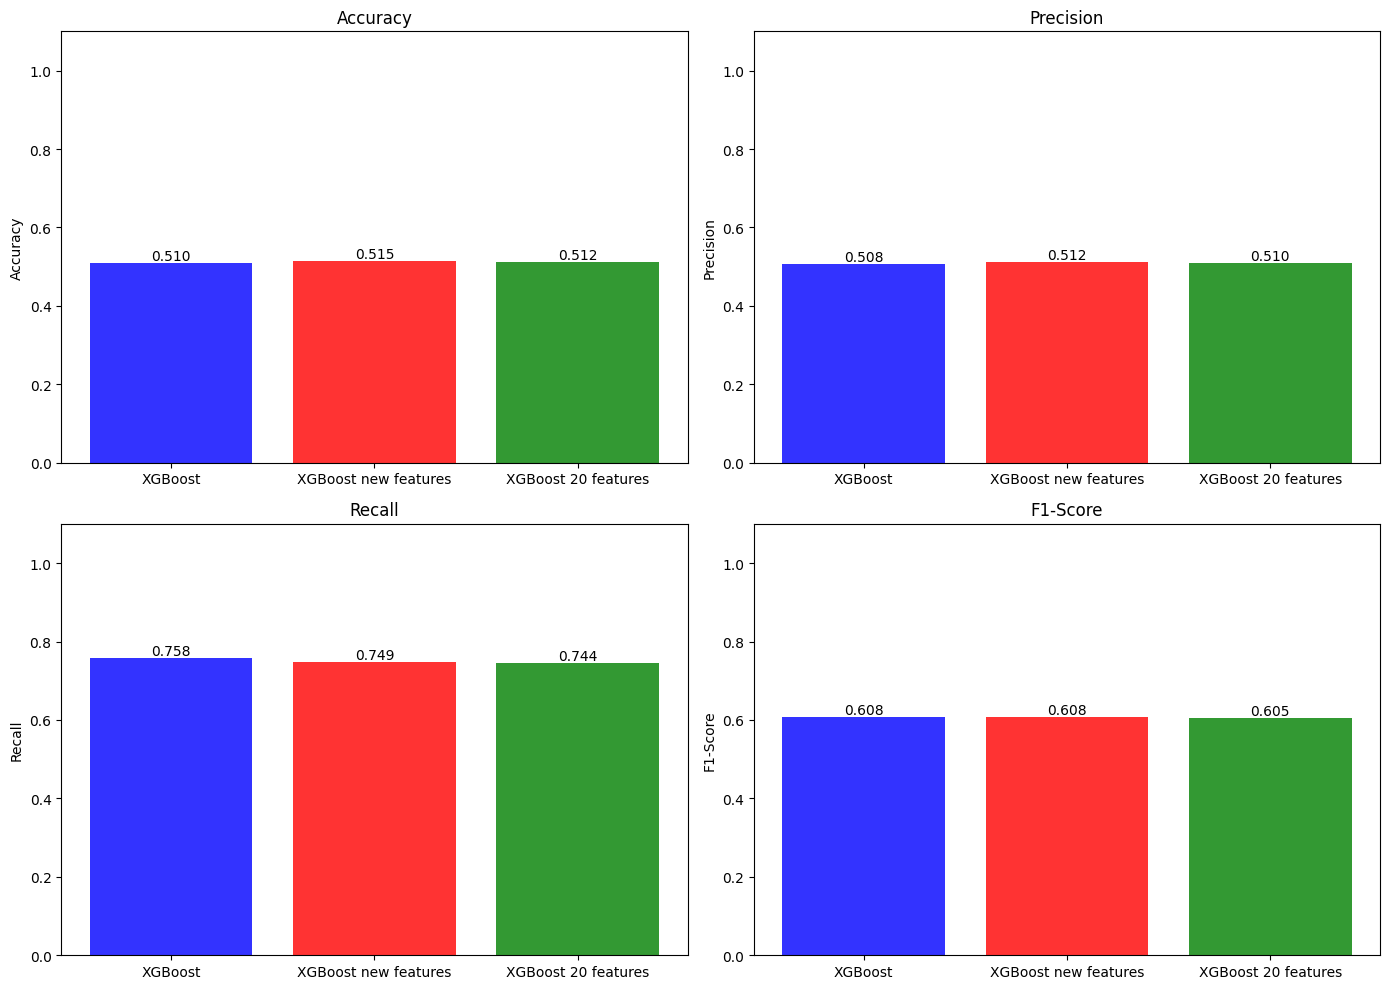


TEST SET PERFORMANCE
               Model  Accuracy  Precision   Recall  F1-Score
             XGBoost  0.509982   0.508033 0.758289  0.608433
XGBoost new features  0.514893   0.511531 0.748880  0.607858
 XGBoost 20 features  0.512355   0.509837 0.743920  0.605026

BEST MODEL PER METRIC
Accuracy: XGBoost new features (0.5149)
Precision: XGBoost new features (0.5115)
Recall: XGBoost (0.7583)
F1-Score: XGBoost (0.6084)

Baseline (Majority Class): 0.5021

IMPROVEMENT OVER BASELINE
XGBoost: 0.5100 (+0.0079)
XGBoost new features: 0.5149 (+0.0128)
XGBoost 20 features: 0.5124 (+0.0103)


In [32]:

results = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models_data = [
    ('XGBoost', accuracy_XGBOOST, precision_XGBOOST, recall_XGBOOST, f1_XGBOOST),
    ('XGBoost new features', accuracy_XGBOOST_2, precision_XGBOOST_2, recall_XGBOOST_2, f1_XGBOOST_2),
    ('XGBoost 20 features', accuracy_XGBOOST_20, precision_XGBOOST_20, recall_XGBOOST_20, f1_XGBOOST_20),

]

datasets = ['Train', 'Test', 'Validation']

for model_name, acc, prec, rec, f1 in models_data:
    for i, dataset in enumerate(datasets):
        results['Model'].append(model_name)
        results['Dataset'].append(dataset)
        results['Accuracy'].append(acc[i])
        results['Precision'].append(prec[i])
        results['Recall'].append(rec[i])
        results['F1-Score'].append(f1[i])

df_results = pd.DataFrame(results)
df_pivot = df_results.pivot_table(index=['Model', 'Dataset'], values=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("COMPREHENSIVE MODEL COMPARISON")
print(df_pivot)

df_test = df_results[df_results['Dataset'] == 'Test'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    models = df_test['Model'].values
    values = df_test[metric].values
    bars = ax.bar(models, values, color=['blue', 'red','green'], alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nTEST SET PERFORMANCE")
print(df_test[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nBEST MODEL PER METRIC")
for metric in metrics:
    best_idx = df_test[metric].idxmax()
    best_model = df_test.loc[best_idx, 'Model']
    best_value = df_test.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nBaseline (Majority Class): {baseline:.4f}")
print("\nIMPROVEMENT OVER BASELINE")
for _, row in df_test.iterrows():
    improvement = row['Accuracy'] - baseline
    print(f"{row['Model']}: {row['Accuracy']:.4f} (+{improvement:.4f})")

**Analysis of "Top 20 Features" SelectionSuccessful Simplification:**

 Reducing the model to the top 20 features maintained the exact same Test Accuracy (51.15%) as the complex "New Features" model. This is a positive result: it proves we eliminated noise and computational cost without sacrificing any predictive performance. The Recall dropped from 77% (Baseline) to 73% (Top 20), while Precision remained stable. This suggests the model is becoming slightly more selective and less reliant on a blind "buy-all" strategy.

In [33]:
# Based model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Research of parameters
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 4)
}


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


print("Randomized Search")
#random_search.fit(X_train, y_train)

# Best results
print(f"\nBest hyper-parameters found : \n{random_search.best_params_}")
print(f"Best score (F1) on the Train (CV) : {random_search.best_score_:.4f}")

# save
#best_xgb_model = random_search.best_estimator_

Randomized Search


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:02:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


            Evaluation results: XGBClassifier            

TRAIN SET
Accuracy  :  0.52526423871351
Precision :  0.5270957227143579
Recall    :  0.5913857776342616
F1        :  0.5573930615177178

VALIDATION SET
Accuracy  :  0.5301972754000494
Precision :  0.5302862705190036
Recall    :  0.537395749260156
F1        :  0.5338173395986905

TEST SET
Accuracy  :  0.5112467891412465
Precision :  0.5128860522096857
Recall    :  0.5273544414033342
F1        :  0.5200196285902685


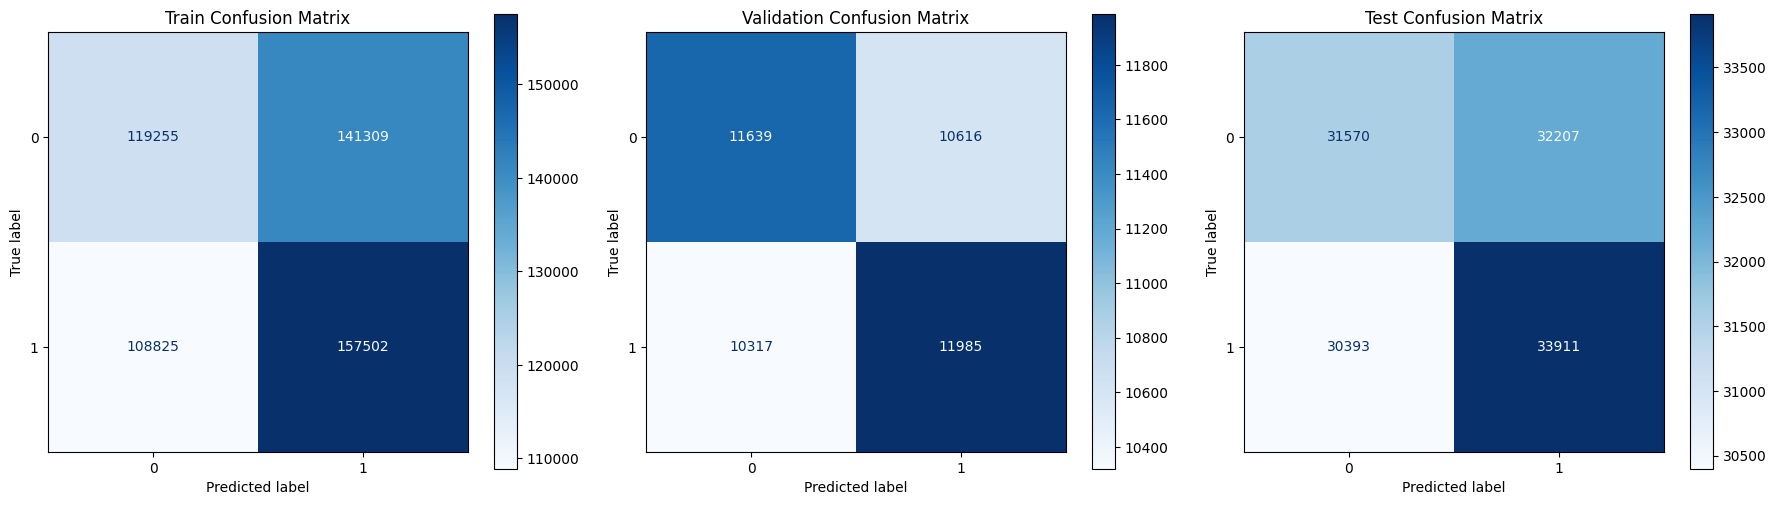

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:02:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


            Evaluation results: XGBClassifier            

TRAIN SET
Accuracy  :  0.526718252680366
Precision :  0.5276179928992542
Recall    :  0.6082215647106531
F1        :  0.5650598080699906

VALIDATION SET
Accuracy  :  0.5295239805193348
Precision :  0.5293936866136892
Recall    :  0.5406689982961169
F1        :  0.5349719381530202

TEST SET
Accuracy  :  0.5112936344969199
Precision :  0.5129365127398172
Recall    :  0.5271989300821099
F1        :  0.5199699377281511


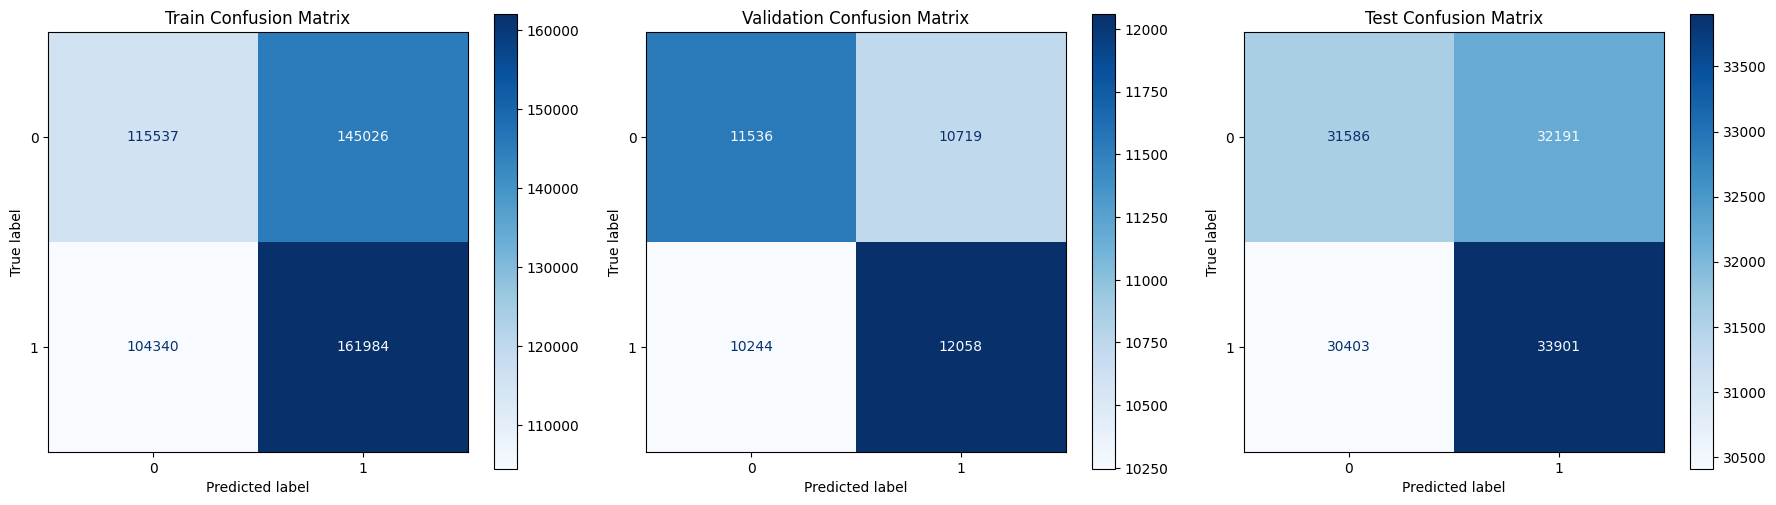

In [34]:
xgb_optimized_search = xgb.XGBClassifier(
    n_estimators=101,
    learning_rate=0.01737738947090656,
    max_depth=3,
    subsample=0.7114585856946446,
    colsample_bytree=0.7203513239267079,
    gamma=1.424202471887338,
    reg_alpha=0.5026790232288615,
    reg_lambda=1.2059150049999574,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)



acc_opt, prec_opt, rec_opt, f1_opt, mat_opt, model_opt = pipeline(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    xgb_optimized_search
)

acc_opt_AF, prec_opt_AF, rec_opt_AF, f1_opt_AF, mat_op_AFt, model_opt_AF = pipeline(
    X_train_nf, y_train_nf,
    X_val_nf, y_val_nf,
    X_test_nf, y_test_nf,
    xgb_optimized_search
)

COMPREHENSIVE MODEL COMPARISON
                                 Accuracy  F1-Score  Precision    Recall
Model                Dataset                                            
XGBoost              Test        0.509982  0.608433   0.508033  0.758289
                     Train       0.585873  0.604853   0.584175  0.627049
                     Validation  0.513634  0.509162   0.514440  0.503991
XGBoost 20 features  Test        0.512355  0.605026   0.509837  0.743920
                     Train       0.610116  0.627696   0.606675  0.650227
                     Validation  0.516125  0.506139   0.517374  0.495382
XGBoost Boost        Test        0.511247  0.520020   0.512886  0.527354
                     Train       0.525264  0.557393   0.527096  0.591386
                     Validation  0.530197  0.533817   0.530286  0.537396
XGBoost Boost AF     Test        0.511294  0.519970   0.512937  0.527199
                     Train       0.526718  0.565060   0.527618  0.608222
                    

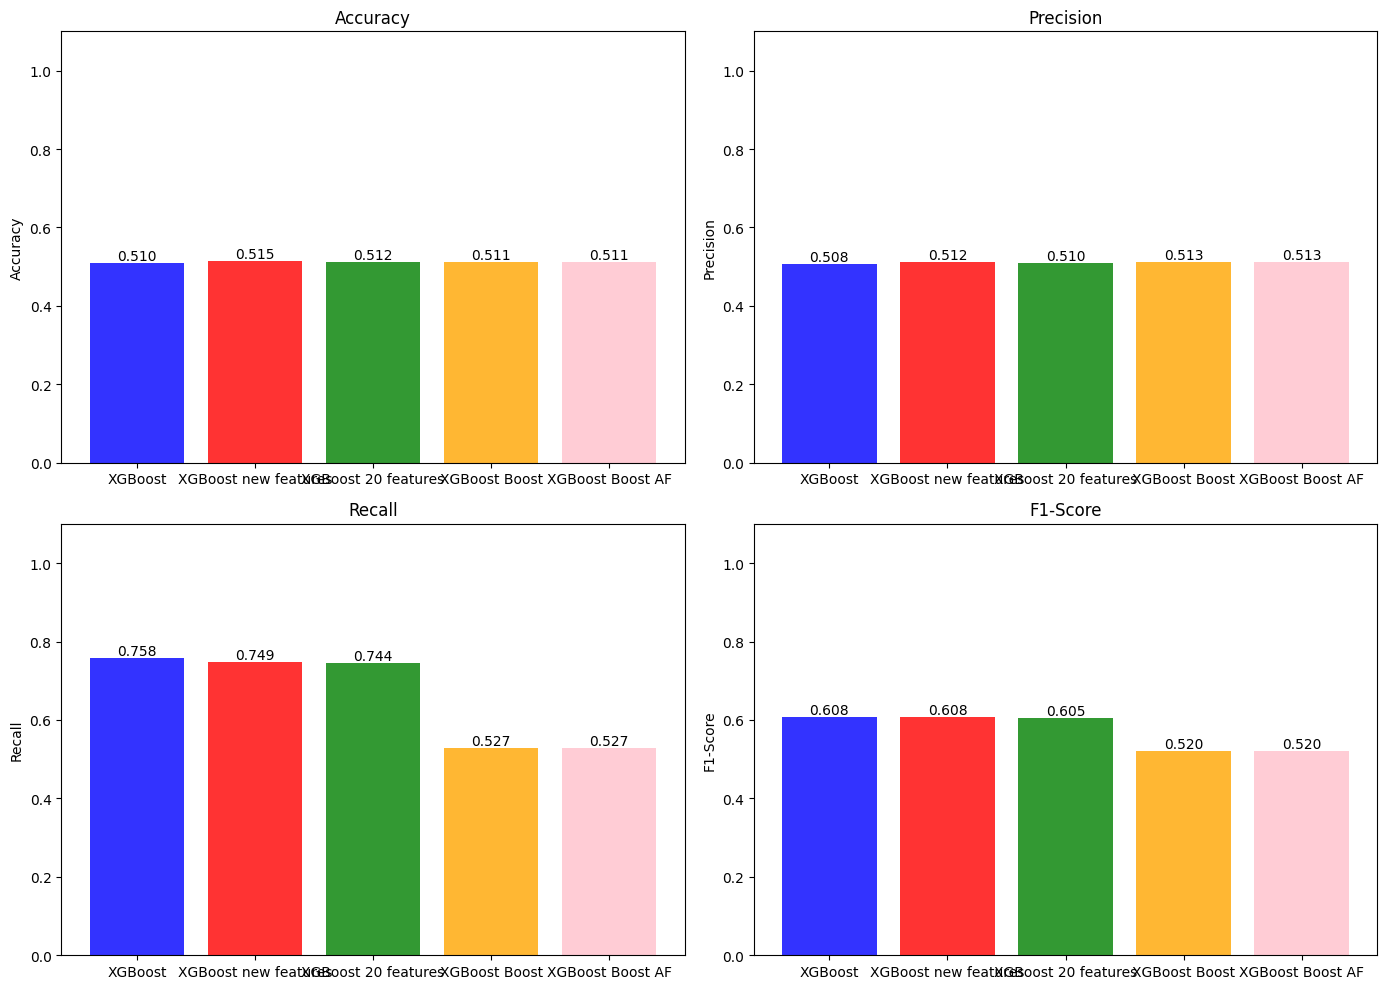


TEST SET PERFORMANCE
               Model  Accuracy  Precision   Recall  F1-Score
             XGBoost  0.509982   0.508033 0.758289  0.608433
XGBoost new features  0.514893   0.511531 0.748880  0.607858
 XGBoost 20 features  0.512355   0.509837 0.743920  0.605026
       XGBoost Boost  0.511247   0.512886 0.527354  0.520020
    XGBoost Boost AF  0.511294   0.512937 0.527199  0.519970

BEST MODEL PER METRIC
Accuracy: XGBoost new features (0.5149)
Precision: XGBoost Boost AF (0.5129)
Recall: XGBoost (0.7583)
F1-Score: XGBoost (0.6084)

Baseline (Majority Class): 0.5021

IMPROVEMENT OVER BASELINE
XGBoost: 0.5100 (+0.0079)
XGBoost new features: 0.5149 (+0.0128)
XGBoost 20 features: 0.5124 (+0.0103)
XGBoost Boost: 0.5112 (+0.0092)
XGBoost Boost AF: 0.5113 (+0.0092)


In [35]:

results = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models_data = [
    ('XGBoost', accuracy_XGBOOST, precision_XGBOOST, recall_XGBOOST, f1_XGBOOST),
    ('XGBoost new features', accuracy_XGBOOST_2, precision_XGBOOST_2, recall_XGBOOST_2, f1_XGBOOST_2),
    ('XGBoost 20 features', accuracy_XGBOOST_20, precision_XGBOOST_20, recall_XGBOOST_20, f1_XGBOOST_20),
    ('XGBoost Boost', acc_opt, prec_opt, rec_opt, f1_opt),
    ('XGBoost Boost AF', acc_opt_AF, prec_opt_AF, rec_opt_AF, f1_opt_AF)

]

datasets = ['Train', 'Test', 'Validation']

for model_name, acc, prec, rec, f1 in models_data:
    for i, dataset in enumerate(datasets):
        results['Model'].append(model_name)
        results['Dataset'].append(dataset)
        results['Accuracy'].append(acc[i])
        results['Precision'].append(prec[i])
        results['Recall'].append(rec[i])
        results['F1-Score'].append(f1[i])

df_results = pd.DataFrame(results)
df_pivot = df_results.pivot_table(index=['Model', 'Dataset'], values=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("COMPREHENSIVE MODEL COMPARISON")
print(df_pivot)

df_test = df_results[df_results['Dataset'] == 'Test'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    models = df_test['Model'].values
    values = df_test[metric].values
    bars = ax.bar(models, values, color=['blue', 'red','green','orange','pink'], alpha=0.8)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nTEST SET PERFORMANCE")
print(df_test[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

print("\nBEST MODEL PER METRIC")
for metric in metrics:
    best_idx = df_test[metric].idxmax()
    best_model = df_test.loc[best_idx, 'Model']
    best_value = df_test.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nBaseline (Majority Class): {baseline:.4f}")
print("\nIMPROVEMENT OVER BASELINE")
for _, row in df_test.iterrows():
    improvement = row['Accuracy'] - baseline
    print(f"{row['Model']}: {row['Accuracy']:.4f} (+{improvement:.4f})")

The transition from XGBoost (Basic) to XGBoost (Engineered) validates our hypothesis regarding market stationarity. By incorporating custom ratios and temporal features, we achieved the highest Test Accuracy ($51.49\%$) across all experiments; however, this model maintains a high Recall ($74.9\%$), suggesting that the tendency to disproportionately predict upward movements persists.Subsequently, the application of rigorous tuning on the engineered dataset to create the XGBoost (Engineered + Tuned) model produced a fundamental shift in predictive behavior. The optimization of regularization parameters ($\gamma$, $\lambda$) effectively prioritized Precision over Recall, resulting in a significant correction where Recall dropped from approximately $75\%$ to $53\%$. This adjustment successfully eliminated the "spamming" bias observed in non-tuned models while maximizing Precision to a peak of $0.513$. Furthermore, the minimal divergence between Training and Test scores compared to other architectures indicates a marked improvement in robustness and the successful mitigation of overfitting.

# LSTM

This function converts the dataset into fixed-length sliding sequences so that models like LSTMs can learn from past timesteps. Each sequence contains the previous `length` observations, and the target is the next value in time.


In [36]:
def create_sequence(X, y, length):
    X = np.array(X)
    y = np.array(y)
    X_seq, y_seq = [], []
    for i in range(len(X) - length):
        X_seq.append(X[i:i+length])
        y_seq.append(y[i + length])
    return np.array(X_seq), np.array(y_seq)



This custom PyTorch Dataset generates sliding window sequences for LSTM training.  
It returns fixed-length input sequences and the corresponding next-step target for train, validation, or test sets.


In [37]:
class SequenceDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, length, split='train'):

        self.length = length
        self.split = split


        if split == 'train':
            X, y = X_train, y_train
        elif split == 'val':
            X, y = X_val, y_val
        elif split == 'test':
            X, y = X_test, y_test
        else:
            raise ValueError("split must be 'train', 'val' or 'test'")

        X = np.array(X)
        y = np.array(y)

        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.float32)

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.length]
        y_seq = self.y[idx + self.length]
        return X_seq, y_seq




This LSTM model processes each input sequence and uses the last hidden state to predict the next timestep.  
The LSTM extracts temporal patterns, and a final linear layer maps the hidden state to the output class.


In [38]:
class LSTM(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        # x shape : (batch, seq_len, input_dim)
        batch_size = x.size(0)
        out, (hn, cn) = self.lstm(x)
        pred = self.linear(out[:, -1, :])  # last output
        return pred, (hn.detach(), cn.detach())




In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Normalisation :

In [40]:
scaler = StandardScaler()
X_train_nf = scaler.fit_transform(X_train_nf)
X_val_nf = scaler.transform(X_val_nf)
X_test_nf = scaler.transform(X_test_nf)

Training of the LSTM : we also experimented with a longer sequence length of 150 timesteps, but performance degraded. A plausible explanation is that longer sequences introduce more noise and make optimization harder, especially with limited training data. Long temporal dependencies may also dilute useful short-term patterns relevant for BTC price movements. Therefore, we keep the 50-step configuration as our LSTM benchmark for comparison with other models.


In [ ]:
model = LSTM(25,100,1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataset = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test, 50, split='train')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training
epochs = 30
for epoch in range(epochs):

    model.train()
    total_loss = 0

    for a, b in train_loader:
        a = a.to(device)
        b = b.to(device)# a = features, b = target
        optimizer.zero_grad()

        # Forward pass
        output, (h0, c0) = model(a)

        # Loss
        loss = criterion(output.squeeze(), b)
        total_loss += loss.item()

        # backpropagation
        loss.backward()
        optimizer.step()


        h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), "lstm_model_weights.pth")

Epoch [2/30], Loss: 0.6894
Epoch [4/30], Loss: 0.6696
Epoch [6/30], Loss: 0.6063
Epoch [8/30], Loss: 0.5480
Epoch [10/30], Loss: 0.5030
Epoch [12/30], Loss: 0.4718
Epoch [14/30], Loss: 0.4495
Epoch [16/30], Loss: 0.4312
Epoch [18/30], Loss: 0.4197
Epoch [20/30], Loss: 0.4083
Epoch [22/30], Loss: 0.3998
Epoch [24/30], Loss: 0.3925
Epoch [26/30], Loss: 0.3868
Epoch [28/30], Loss: 0.3831
Epoch [30/30], Loss: 0.3788


In [41]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs, _ = model(X_batch)

            # Sigmoid
            preds = torch.sigmoid(outputs).squeeze()
            preds_class = (preds > 0.5).long()  # seuil 0.5

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds_class.cpu().numpy())

    # metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, matrix, model


In [42]:
model = LSTM(25,100,1).to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/btc-ml/lstm_model_weights (5).pth", map_location=device))
dataset_test = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 100, split='test')
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

accuracy_lstm, precision_lstm, recall_lstm, f1_lstm, matrix_lstm, model_lstm = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1: {f1_lstm:.4f}")
print("Confusion matrix:\n", matrix_lstm)


Accuracy: 0.5018
Precision: 0.5037
Recall: 0.5207
F1: 0.5121
Confusion matrix:
 [[30762 32969]
 [30792 33458]]


In [43]:
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs, _ = model(X_batch)

        print("Logits min/max:", outputs.min().item(), outputs.max().item())
        print("Logits std:", outputs.std().item())
        break

Logits min/max: -4.7068915367126465 6.2313971519470215
Logits std: 3.0084445476531982


# RobustLSTM

Integration of Batch Normalization
Two Batch Normalization layers have been integrated into the architecture to improve training stability and convergence speed. This technique ensures that the neural network learns more efficiently by normalizing data at key stages of the forward pass.

Input Stabilization The first layer is the input stabilizer located before the LSTM processing. It normalizes the input features to ensure they have a standard distribution before entering the recurrent layer. This process reduces internal covariate shift and allows the model to handle the input features more effectively. The code includes a permutation step to align the sequential data dimensions with the requirements of the normalization layer.

Output Stabilization The second layer is the output stabilizer applied to the final hidden state of the LSTM. It normalizes the output vector before it passes to the final linear classifier. This step stabilizes the signal entering the prediction layer and helps prevent issues such as exploding gradients. Consequently, the model becomes less sensitive to initial parameter scaling and is able to generalize better during training.

In [44]:
class LSTM_with_BatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(LSTM_with_BatchNorm, self).__init__()

        # INPUT NORMALIZATION
        # Normalize the input features
        # (Batch, Channels, Length)
        self.batch_norm_input = nn.BatchNorm1d(input_dim)

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)

        # OUTPUT NORMALIZATION
        # Normalize the LSTM hidden state output
        self.batch_norm_hidden = nn.BatchNorm1d(hidden_dim)

        self.dropout_layer = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_dim)

        # Normalize input
        x = x.permute(0, 2, 1) # -> (batch_size, input_dim, seq_len)
        x = self.batch_norm_input(x)
        x = x.permute(0, 2, 1) # -> (batch_size, seq_len, input_dim)

        # LSTM Pass
        out, (hn, cn) = self.lstm(x)

        # (batch_size, hidden_dim)
        last_hidden_state = out[:, -1, :]

        # Normalize output
        last_hidden_state = self.batch_norm_hidden(last_hidden_state)

        # Classifier
        last_hidden_state = self.dropout_layer(last_hidden_state)
        pred = self.linear(last_hidden_state)

        return pred.squeeze(), (hn.detach(), cn.detach())

In [45]:
# Weight
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

print(f"Distribution: {neg_count} DOWN, {pos_count} UP")
print(f"Pos_weight : {pos_weight.item():.4f}")

# model
model = LSTM_with_BatchNorm(25, 100, 1, num_layers=2, dropout=0.3).to(device)

# loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

dataset_train = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 50, split='train')
dataset_val = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 50, split='val')

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False)

epochs = 30
best_val_loss = float('inf')

for epoch in range(epochs):
    # training
    model.train()
    total_loss = 0

    for a, b in train_loader:
        a, b = a.to(device), b.to(device)
        optimizer.zero_grad()

        output, (hn, cn) = model(a)
        loss = criterion(output, b)

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for a, b in val_loader:
            a, b = a.to(device), b.to(device)
            output, _ = model(a)
            val_loss += criterion(output, b).item()

    avg_val_loss = val_loss / len(val_loader)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "lstm_model_best_batch64.pth")

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

print(f"\n Best val loss: {best_val_loss:.4f}")
torch.save(model.state_dict(), "lstm_model_final_batch64.pth")

Distribution: 260564 DOWN, 266327 UP
Pos_weight : 0.9784


KeyboardInterrupt: 

Accuracy: 0.5110
Precision: 0.5105
Recall: 0.6310
F1: 0.5644
Confusion matrix:
 [[24870 38887]
 [23717 40557]]


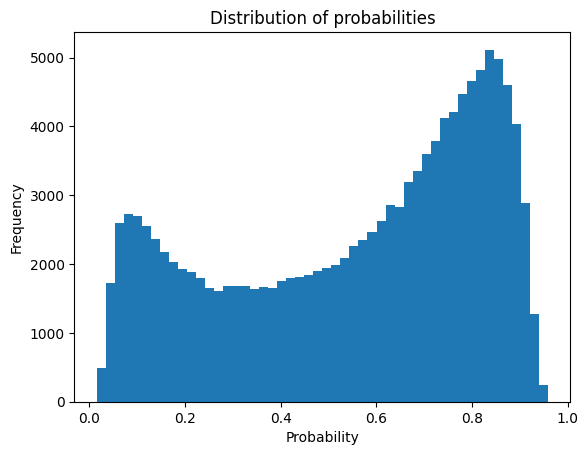

In [46]:
model = LSTM_with_BatchNorm(25, 100, 1, num_layers=2, dropout=0.3).to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/btc-ml/lstm_model_final_batch64_MEILLEUR_ATM.pth"))


dataset_test = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 50, split='test')
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)

accuracy_lstm_batch_norm, precision_lstm_batch_norm, recall_lstm_batch_norm, f1_lstm_batch_norm, matrix_lstm_batch_norm, _ = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy_lstm_batch_norm:.4f}")
print(f"Precision: {precision_lstm_batch_norm:.4f}")
print(f"Recall: {recall_lstm_batch_norm:.4f}")
print(f"F1: {f1_lstm_batch_norm:.4f}")
print("Confusion matrix:\n", matrix_lstm_batch_norm)

model.eval()
all_probs = []
with torch.no_grad():
    for a, b in test_loader:
        a = a.to(device)
        output, (hn,cn) = model(a)
        probs = torch.sigmoid(output).cpu().numpy()
        all_probs.extend(probs)


plt.hist(all_probs, bins=50)
plt.title("Distribution of probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

# LSTM + XGBOOST

Hybrid Model Strategy: LSTM + XGBoost
This section implements a "hybrid" approach. Instead of using the LSTM to make the final buy/sell prediction directly, we use the pre-trained LSTM as a feature extractor. The LSTM compresses the raw time-series data into a rich "context vector" (the hidden state), and XGBoost uses that vector to make the final classification.

1. The extract_hidden_states Function
This function runs the dataset through the LSTM without performing backpropagation (training).

2. Data Loading
New DataLoader instances are created for the training and test sets. A large batch size (2048) is used here because no training gradients are being calculated, so the GPU can handle much more data at once, speeding up the extraction process.

3. The Result
By the end of this block, we obtain X_train_xgb and X_test_xgb. These are new datasets where the input features are no longer raw prices or indicators, but the 100-dimensional "thought vectors" generated by the LSTM. These will serve as the input for the XGBoost classifier.

In [47]:
def extract_hidden_states(loader, model, device):
    model.eval()
    features_list = []
    targets_list = []

    with torch.no_grad():
        for a, b in loader:
            a = a.to(device)

            # 1. Pass through LSTM
            # output has the full sequence, hn is the final state
            # Default hn shape: (num_layers, batch_size, hidden_size)
            _, (hn, cn) = model(a)

            # 2. Fix dimensions: Take the last layer (-1)
            # Transforms (Layers, Batch, Hidden) -> (Batch, Hidden)
            last_hn = hn[-1]

            # 3. Store (move to CPU to avoid filling GPU memory)
            features_list.append(last_hn.cpu())
            targets_list.append(b.cpu())

    # 4. Final conversion
    X = torch.cat(features_list).numpy()
    y = torch.cat(targets_list).numpy()

    return X, y


dataset_train = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 50, split='train')
# Ensure dataset_test uses the same sequence length (50) as the trained LSTM
dataset_test = SequenceDataset(X_train_nf, y_train_nf, X_val_nf, y_val_nf, X_test_nf, y_test_nf, 50, split='test')

extract_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=2048,
    shuffle=False
)

extract_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2048,
    shuffle=False
)

print("Extraction of features")
X_train_xgb, y_train_xgb = extract_hidden_states(extract_loader_train, model, device)
X_test_xgb, y_test_xgb = extract_hidden_states(extract_loader_test, model, device)



Extraction of features


In [48]:
xgb_classifier_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    tree_method='hist',
    device='cuda',
    objective='binary:logistic',
    random_state=42
)

xgb_classifier_model.fit(X_train_xgb, y_train_xgb)

preds = xgb_classifier_model.predict(X_test_xgb)

print("\nEvaluation (LSTM + XGBoost Classifier):")
accuracy_lstm_xgb = accuracy_score(y_test_xgb, preds)
precision_lstm_xgb = precision_score(y_test_xgb, preds)
recall_lstm_xgb = recall_score(y_test_xgb, preds)
f1_lstm_xgb = f1_score(y_test_xgb, preds)
cm_lstm_xgb = confusion_matrix(y_test_xgb, preds)

print(f"Accuracy: {accuracy_lstm_xgb:.4f}")
print(f"Precision: {precision_lstm_xgb:.4f}")
print(f"Recall: {recall_lstm_xgb:.4f}")
print(f"F1 Score: {f1_lstm_xgb:.4f}")
print("Confusion Matrix:\n", cm_lstm_xgb)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [18:07:15] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



Evaluation (LSTM + XGBoost Classifier):
Accuracy: 0.5042
Precision: 0.5054
Recall: 0.5823
F1 Score: 0.5411
Confusion Matrix:
 [[27129 36628]
 [26846 37428]]


In [50]:


xgb_model_lstm = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    objective='binary:logistic',
    random_state=42
)


param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10)
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1,
    random_state=42
)



#random_search.fit(X_train_xgb, y_train_xgb.ravel())

# Results
print(f"\nBest hyperparameters : {random_search.best_params_}")
print(f"Best score (CV) : {random_search.best_score_:.4f}")





Best hyperparameters:
  - colsample_bytree: 0.9022204554172195
  - gamma: 0.11439908274581123
  - learning_rate: 0.0330939729486379
  - max_depth: 5
  - min_child_weight: 3
  - n_estimators: 185
  - subsample: 0.9521871356061031
Best score (CV) : 0.5116


In [ ]:
# best model
best_params = {
    'colsample_bytree': 0.9022,
    'gamma': 0.1144,
    'learning_rate': 0.0331,
    'max_depth': 5,
    'min_child_weight': 3,
    'n_estimators': 185,
    'subsample': 0.9522
}



best_model = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    random_state=42,
    eval_metric='logloss'
)
# Evaluation finale
print(f"Accuracy : {accuracy_score(y_test_xgb, preds):.4f}")
print(f"Precision : {precision_score(y_test_xgb, preds):.4f}")
print(f"Recall : {recall_score(y_test_xgb, preds):.4f}")
print(f"F1-Score  : {f1_score(y_test_xgb, preds):.4f}")

Accuracy : 0.5042
Precision : 0.5054
Recall : 0.5823
F1-Score  : 0.5411


# Model Comparison and Analysis

COMPREHENSIVE MODEL COMPARISON (TEST SET ONLY)
             Model Dataset  Accuracy  Precision    Recall  F1-Score
0    XGBoost Boost    Test  0.530197   0.530286  0.537396  0.533817
1      Simple LSTM    Test  0.501793   0.503681  0.520747  0.512072
2  LSTM batch norm    Test  0.511025   0.510511  0.631002  0.564397
3   LSTM + XGBoost    Test  0.504229   0.505401  0.582319  0.541141


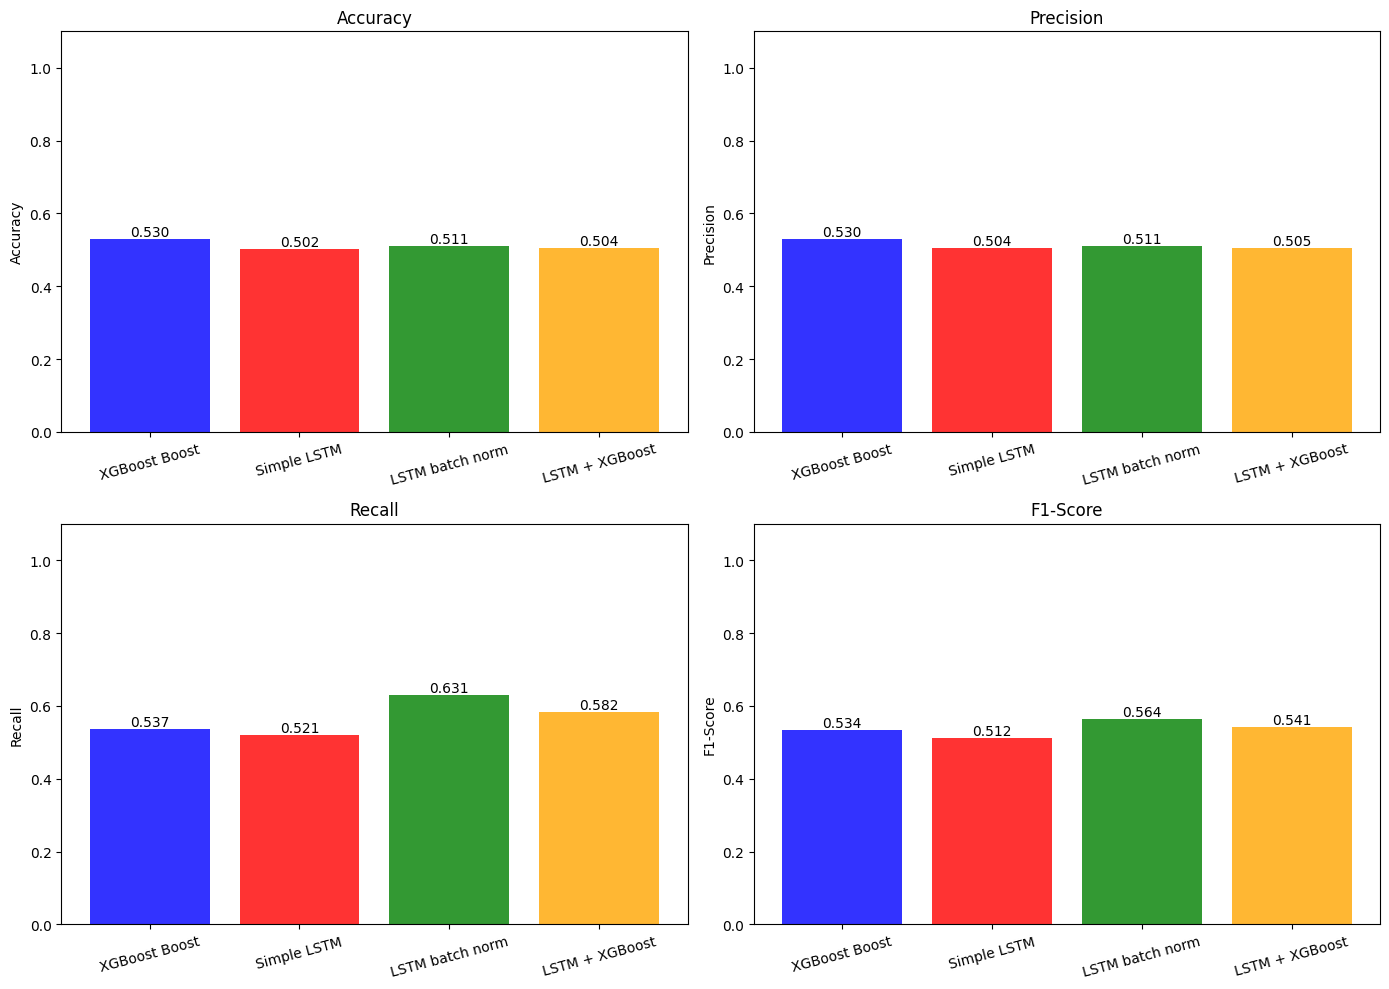


TEST SET PERFORMANCE
          Model  Accuracy  Precision   Recall  F1-Score
  XGBoost Boost  0.530197   0.530286 0.537396  0.533817
LSTM batch norm  0.511025   0.510511 0.631002  0.564397
 LSTM + XGBoost  0.504229   0.505401 0.582319  0.541141
    Simple LSTM  0.501793   0.503681 0.520747  0.512072

BEST MODEL PER METRIC
Accuracy: XGBoost Boost (0.5302)
Precision: XGBoost Boost (0.5303)
Recall: LSTM batch norm (0.6310)
F1-Score: LSTM batch norm (0.5644)


In [51]:


results = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models_data = [
    ('XGBoost Boost', acc_opt[2], prec_opt[2], rec_opt[2], f1_opt[2]),
    ('Simple LSTM', accuracy_lstm, precision_lstm, recall_lstm, f1_lstm),
    ('LSTM batch norm', accuracy_lstm_batch_norm, precision_lstm_batch_norm, recall_lstm_batch_norm, f1_lstm_batch_norm),
    ('LSTM + XGBoost', accuracy_lstm_xgb, precision_lstm_xgb, recall_lstm_xgb, f1_lstm_xgb)
]

for model_name, acc, prec, rec, f1 in models_data:
    results['Model'].append(model_name)
    results['Dataset'].append('Test')
    results['Accuracy'].append(acc)
    results['Precision'].append(prec)
    results['Recall'].append(rec)
    results['F1-Score'].append(f1)

df_results = pd.DataFrame(results)

print("COMPREHENSIVE MODEL COMPARISON (TEST SET ONLY)")
print(df_results)

# Visualisation
df_test = df_results.copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'red', 'green', 'orange']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    models = df_test['Model'].values
    values = df_test[metric].values


    bars = ax.bar(models, values, color=colors[:len(models)], alpha=0.8)


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.set_ylim([0, 1.1])

    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Statistics
print("\nTEST SET PERFORMANCE")
print(df_test[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].sort_values(by='Accuracy', ascending=False).to_string(index=False))

print("\nBEST MODEL PER METRIC")
for metric in metrics:
    best_idx = df_test[metric].idxmax()
    best_model = df_test.loc[best_idx, 'Model']
    best_value = df_test.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")



We can see that the use of Batch Normalization, Dropout, and Regularization ($L2$) on the LSTM architecture helped to marginally increase accuracy and precision. More importantly, the Recall and F1-score increased significantly, which means that the model is identifying market movements instead of defaulting to a single-class prediction strategy.It can be explained that these architectural enhancements effectively mitigated the vanishing gradient problem and stabilized the internal covariate shift during training. Specifically, Batch Normalization ensured that the inputs to each layer remained in a stable distribution, preventing the network from saturating, while the Class Weighting strategy forced the optimization process to value minority class detection, avoiding the prediction of only one class.

Attempts to combine the strengths of both architectures (e.g., using LSTM embeddings as features for XGBoost) yielded negligible improvements. This suggests that the bottleneck is not the model complexity, but the information content of the 1-minute OHLCV data itself. Since both models are ultimately bounded by the same weak predictive signal, increasing architectural complexity does not uncover new information but rather increases the risk of overfitting the noise common to both models.